Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0


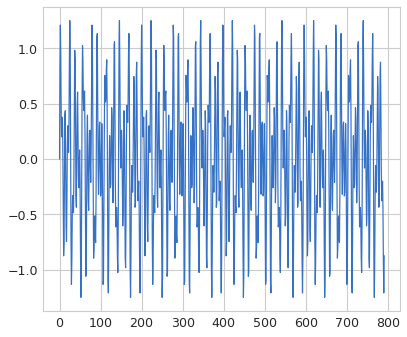

Signal Length M=792


In [3]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import sys
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import signalz

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:2'

signal = []
for x in range(198*4):
    signal.append(.5*np.sin(2*np.pi*x/(18))+\
                  .5*np.sin(2*np.pi*x/(6)) +\
                  .5*np.sin(2*np.pi*x/(11)))
signal = np.array(signal)
FREERUN  = 0 #198
plt.plot(signal)
plt.show()

M = signal.shape[0]-FREERUN

K = 1
L = 1
RF = .5
TEST = 198*2
LEAD = 198
BURNIN = 198
REG = 1e-8
TRAINLENGTH = M-TEST
CALLS = 150
MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
print(f'Signal Length M={M}')

In [4]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [5]:
min_a, max_a = .001, 1.
min_sr, max_sr = .001, 1.2
min_g, max_g = .001, 1.
min_ri, max_ri = .001, 1.
min_rr, max_rr = .001, 5.
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, signal, counter, N, ref, rn, \
           alphas, rhos, gammas, inScales, resScales
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                         device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype,
                         device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 
        
    state = states.detach().cpu().numpy()

    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    torch.cuda.synchronize()

    predictions = torch.zeros((M+FREERUN,1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+FREERUN):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST],
                          yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST],
                          MINMAX) 
    except:
        pass
        
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000

    if((loss < running_error) & (loss < .14)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        #ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-2,2)
        ax1.legend()
        plt.show()
        fig.savefig(f'./S2_Saved_Models/S2_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./S2_Saved_Models/S2_it{counter}_{N}_{ref}_{rn}_Wnet',wnet)
        np.save(f'./S2_Saved_Models/S2_it{counter}_{N}_{ref}_{rn}_Preds',yHat_GPU)
        np.save(f'./S2_Saved_Models/S2_it{counter}_{N}_{ref}_{rn}_InstanceParams',currentParams)  
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    
    print(f'Iter: {counter} #### Diagnostic {loss:.3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {nrmse:.3f} CD {dist:.3f}')
    
    counter += 1
    return loss


 ********** 300 ***********
Iter: 0 #### Diagnostic 0.246   Time 10.29  Best 1000.000 NRMSE 0.246 CD 0.917
Iter: 1 #### Diagnostic 0.265   Time 1.43  Best 1000.000 NRMSE 0.265 CD 1.004
Iter: 2 #### Diagnostic 0.300   Time 1.39  Best 1000.000 NRMSE 0.300 CD 0.949
Iter: 3 #### Diagnostic 0.335   Time 0.94  Best 1000.000 NRMSE 0.335 CD 1.042
Iter: 4 #### Diagnostic 0.246   Time 1.12  Best 1000.000 NRMSE 0.246 CD 0.970
Iter: 5 #### Diagnostic 0.250   Time 0.86  Best 1000.000 NRMSE 0.250 CD 0.760
Iter: 6 #### Diagnostic 0.255   Time 0.80  Best 1000.000 NRMSE 0.255 CD 0.965
Iter: 7 #### Diagnostic 0.264   Time 0.98  Best 1000.000 NRMSE 0.264 CD 0.976
Iter: 8 #### Diagnostic 0.244   Time 0.95  Best 1000.000 NRMSE 0.244 CD 0.878
Iter: 9 #### Diagnostic 0.186   Time 1.24  Best 1000.000 NRMSE 0.186 CD 0.306
Iter: 10 #### Diagnostic 0.248   Time 0.80  Best 1000.000 NRMSE 0.248 CD 0.934
Iter: 11 #### Diagnostic 0.259   Time 0.78  Best 1000.000 NRMSE 0.259 CD 0.889
Iter: 12 #### Diagnostic 0.268  

Iter: 2 #### Diagnostic 0.245   Time 0.68  Best 1000.000 NRMSE 0.245 CD 0.933
Iter: 3 #### Diagnostic 0.244   Time 0.41  Best 1000.000 NRMSE 0.244 CD 0.899
Iter: 4 #### Diagnostic 0.311   Time 0.97  Best 1000.000 NRMSE 0.311 CD 0.996
Iter: 5 #### Diagnostic 0.332   Time 1.13  Best 1000.000 NRMSE 0.332 CD 1.005
Iter: 6 #### Diagnostic 0.297   Time 0.83  Best 1000.000 NRMSE 0.297 CD 0.989
Iter: 7 #### Diagnostic 0.243   Time 1.17  Best 1000.000 NRMSE 0.243 CD 0.875
Iter: 8 #### Diagnostic 0.248   Time 0.38  Best 1000.000 NRMSE 0.248 CD 0.941
Iter: 9 #### Diagnostic 0.332   Time 0.47  Best 1000.000 NRMSE 0.332 CD 0.987
Iter: 10 #### Diagnostic 0.251   Time 0.93  Best 1000.000 NRMSE 0.251 CD 0.946
Iter: 11 #### Diagnostic 0.296   Time 0.70  Best 1000.000 NRMSE 0.296 CD 0.900
Iter: 12 #### Diagnostic 0.244   Time 1.04  Best 1000.000 NRMSE 0.244 CD 0.908
Iter: 13 #### Diagnostic 0.246   Time 0.95  Best 1000.000 NRMSE 0.246 CD 1.011
Iter: 14 #### Diagnostic 0.243   Time 0.91  Best 1000.000 NR

Iter: 4 #### Diagnostic 0.261   Time 0.92  Best 1000.000 NRMSE 0.261 CD 0.983
Iter: 5 #### Diagnostic 0.341   Time 0.41  Best 1000.000 NRMSE 0.341 CD 0.974
Iter: 6 #### Diagnostic 0.221   Time 0.39  Best 1000.000 NRMSE 0.221 CD 0.550
Iter: 7 #### Diagnostic 0.262   Time 0.58  Best 1000.000 NRMSE 0.262 CD 0.984
Iter: 8 #### Diagnostic 0.259   Time 0.56  Best 1000.000 NRMSE 0.259 CD 0.972
Iter: 9 #### Diagnostic 0.193   Time 0.28  Best 1000.000 NRMSE 0.193 CD 0.302
Iter: 10 #### Diagnostic 0.247   Time 0.38  Best 1000.000 NRMSE 0.247 CD 0.979
Iter: 11 #### Diagnostic 0.317   Time 0.41  Best 1000.000 NRMSE 0.317 CD 1.037
Iter: 12 #### Diagnostic 0.325   Time 0.57  Best 1000.000 NRMSE 0.325 CD 0.971
Iter: 13 #### Diagnostic 0.253   Time 0.49  Best 1000.000 NRMSE 0.253 CD 0.958
Iter: 14 #### Diagnostic 0.244   Time 0.35  Best 1000.000 NRMSE 0.244 CD 0.928
Iter: 15 #### Diagnostic 0.244   Time 0.48  Best 1000.000 NRMSE 0.244 CD 0.906
Iter: 16 #### Diagnostic 0.243   Time 0.56  Best 1000.000 

Iter: 6 #### Diagnostic 0.239   Time 1.23  Best 1000.000 NRMSE 0.239 CD 0.779
Iter: 7 #### Diagnostic 0.244   Time 1.04  Best 1000.000 NRMSE 0.244 CD 0.892
Iter: 8 #### Diagnostic 0.248   Time 0.82  Best 1000.000 NRMSE 0.248 CD 0.914
Iter: 9 #### Diagnostic 0.244   Time 0.94  Best 1000.000 NRMSE 0.244 CD 0.913
Iter: 10 #### Diagnostic 0.244   Time 1.05  Best 1000.000 NRMSE 0.244 CD 0.898
Iter: 11 #### Diagnostic 0.275   Time 0.89  Best 1000.000 NRMSE 0.275 CD 1.025
Iter: 12 #### Diagnostic 0.251   Time 0.70  Best 1000.000 NRMSE 0.251 CD 0.952
Iter: 13 #### Diagnostic 0.247   Time 0.29  Best 1000.000 NRMSE 0.247 CD 0.919
Iter: 14 #### Diagnostic 0.224   Time 0.30  Best 1000.000 NRMSE 0.224 CD 0.582
Iter: 15 #### Diagnostic 0.245   Time 0.32  Best 1000.000 NRMSE 0.245 CD 0.947
Iter: 16 #### Diagnostic 1.187   Time 0.41  Best 1000.000 NRMSE 1.187 CD 0.990
Iter: 17 #### Diagnostic 0.259   Time 0.33  Best 1000.000 NRMSE 0.259 CD 0.967
Iter: 18 #### Diagnostic 0.245   Time 0.66  Best 1000.00

Iter: 8 #### Diagnostic 0.245   Time 0.66  Best 1000.000 NRMSE 0.245 CD 0.935
Iter: 9 #### Diagnostic 0.276   Time 0.78  Best 1000.000 NRMSE 0.276 CD 1.001
Iter: 10 #### Diagnostic 0.246   Time 0.93  Best 1000.000 NRMSE 0.246 CD 0.978
Iter: 11 #### Diagnostic 0.243   Time 0.87  Best 1000.000 NRMSE 0.243 CD 0.858
Iter: 12 #### Diagnostic 0.314   Time 1.01  Best 1000.000 NRMSE 0.314 CD 0.973
Iter: 13 #### Diagnostic 0.245   Time 0.88  Best 1000.000 NRMSE 0.245 CD 0.895
Iter: 14 #### Diagnostic 0.300   Time 0.90  Best 1000.000 NRMSE 0.300 CD 1.039
Iter: 15 #### Diagnostic 0.239   Time 1.27  Best 1000.000 NRMSE 0.239 CD 0.396
Iter: 16 #### Diagnostic 0.262   Time 1.04  Best 1000.000 NRMSE 0.262 CD 0.997
Iter: 17 #### Diagnostic 0.331   Time 0.88  Best 1000.000 NRMSE 0.331 CD 0.986
Iter: 18 #### Diagnostic 0.322   Time 0.90  Best 1000.000 NRMSE 0.322 CD 0.976
Iter: 19 #### Diagnostic 0.242   Time 0.73  Best 1000.000 NRMSE 0.242 CD 0.736
Iter: 20 #### Diagnostic 0.248   Time 0.56  Best 1000.

Iter: 8 #### Diagnostic 0.244   Time 1.07  Best 1000.000 NRMSE 0.244 CD 0.880
Iter: 9 #### Diagnostic 0.217   Time 1.29  Best 1000.000 NRMSE 0.217 CD 0.393
Iter: 10 #### Diagnostic 0.248   Time 1.38  Best 1000.000 NRMSE 0.248 CD 0.933
Iter: 11 #### Diagnostic 0.242   Time 0.75  Best 1000.000 NRMSE 0.242 CD 0.805
Iter: 12 #### Diagnostic 0.256   Time 0.64  Best 1000.000 NRMSE 0.256 CD 0.976
Iter: 13 #### Diagnostic 0.251   Time 0.80  Best 1000.000 NRMSE 0.251 CD 0.936
Iter: 14 #### Diagnostic 0.242   Time 1.12  Best 1000.000 NRMSE 0.242 CD 0.848
Iter: 15 #### Diagnostic 0.244   Time 1.49  Best 1000.000 NRMSE 0.244 CD 0.872
Iter: 16 #### Diagnostic 0.271   Time 0.81  Best 1000.000 NRMSE 0.271 CD 0.998
Iter: 17 #### Diagnostic 0.244   Time 0.87  Best 1000.000 NRMSE 0.244 CD 0.861
Iter: 18 #### Diagnostic 0.244   Time 0.86  Best 1000.000 NRMSE 0.244 CD 0.891
Iter: 19 #### Diagnostic 0.246   Time 0.66  Best 1000.000 NRMSE 0.246 CD 0.999
Iter: 20 #### Diagnostic 0.281   Time 1.22  Best 1000.

Iter: 10 #### Diagnostic 0.247   Time 0.81  Best 1000.000 NRMSE 0.247 CD 0.925
Iter: 11 #### Diagnostic 0.258   Time 0.81  Best 1000.000 NRMSE 0.258 CD 0.979
Iter: 12 #### Diagnostic 0.242   Time 0.49  Best 1000.000 NRMSE 0.242 CD 0.846
Iter: 13 #### Diagnostic 0.482   Time 0.65  Best 1000.000 NRMSE 0.482 CD 0.990
Iter: 14 #### Diagnostic 0.243   Time 0.43  Best 1000.000 NRMSE 0.243 CD 0.858
Iter: 15 #### Diagnostic 0.243   Time 0.47  Best 1000.000 NRMSE 0.243 CD 0.867
Iter: 16 #### Diagnostic 0.245   Time 0.39  Best 1000.000 NRMSE 0.245 CD 0.905
Iter: 17 #### Diagnostic 0.242   Time 0.38  Best 1000.000 NRMSE 0.242 CD 0.837
Iter: 18 #### Diagnostic 0.245   Time 0.91  Best 1000.000 NRMSE 0.245 CD 0.909
Iter: 19 #### Diagnostic 1000.000   Time 1.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 0.244   Time 1.10  Best 1000.000 NRMSE 0.244 CD 0.891
Iter: 21 #### Diagnostic 0.302   Time 0.93  Best 1000.000 NRMSE 0.302 CD 0.999
Iter: 22 #### Diagnostic 0.246   Time 0.88  Best

Iter: 12 #### Diagnostic 0.243   Time 0.76  Best 1000.000 NRMSE 0.243 CD 0.717
Iter: 13 #### Diagnostic 0.243   Time 1.23  Best 1000.000 NRMSE 0.243 CD 0.754
Iter: 14 #### Diagnostic 0.245   Time 0.99  Best 1000.000 NRMSE 0.245 CD 0.934
Iter: 15 #### Diagnostic 0.244   Time 0.95  Best 1000.000 NRMSE 0.244 CD 0.902
Iter: 16 #### Diagnostic 0.246   Time 0.63  Best 1000.000 NRMSE 0.246 CD 0.955
Iter: 17 #### Diagnostic 0.253   Time 0.75  Best 1000.000 NRMSE 0.253 CD 0.966
Iter: 18 #### Diagnostic 0.322   Time 0.54  Best 1000.000 NRMSE 0.322 CD 0.967
Iter: 19 #### Diagnostic 0.360   Time 0.69  Best 1000.000 NRMSE 0.360 CD 0.997
Iter: 20 #### Diagnostic 0.312   Time 0.98  Best 1000.000 NRMSE 0.312 CD 1.130
Iter: 21 #### Diagnostic 0.246   Time 1.00  Best 1000.000 NRMSE 0.246 CD 0.986
Iter: 22 #### Diagnostic 0.361   Time 0.77  Best 1000.000 NRMSE 0.361 CD 0.971
Iter: 23 #### Diagnostic 0.248   Time 0.45  Best 1000.000 NRMSE 0.248 CD 0.927
Iter: 24 #### Diagnostic 0.281   Time 0.32  Best 100

Iter: 14 #### Diagnostic 0.238   Time 0.59  Best 1000.000 NRMSE 0.238 CD 0.755
Iter: 15 #### Diagnostic 0.246   Time 0.67  Best 1000.000 NRMSE 0.246 CD 0.980
Iter: 16 #### Diagnostic 0.265   Time 0.70  Best 1000.000 NRMSE 0.265 CD 1.006
Iter: 17 #### Diagnostic 0.267   Time 0.81  Best 1000.000 NRMSE 0.267 CD 1.006
Iter: 18 #### Diagnostic 0.245   Time 0.58  Best 1000.000 NRMSE 0.245 CD 0.942
Iter: 19 #### Diagnostic 0.367   Time 0.47  Best 1000.000 NRMSE 0.367 CD 1.174
Iter: 20 #### Diagnostic 0.243   Time 0.89  Best 1000.000 NRMSE 0.243 CD 0.877
Iter: 21 #### Diagnostic 0.243   Time 0.83  Best 1000.000 NRMSE 0.243 CD 0.878
Iter: 22 #### Diagnostic 0.336   Time 0.55  Best 1000.000 NRMSE 0.336 CD 1.051


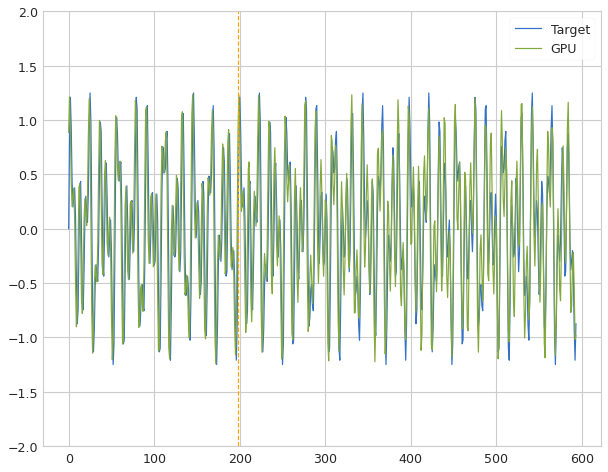

 Iter=23 a=0.566 sr=1.122 amp=0.818  ri=0.633 rr=3.777 loss=0.131962


Iter: 23 #### Diagnostic 0.132   Time 1.71  Best 0.132 NRMSE 0.132 CD 0.143
Iter: 24 #### Diagnostic 0.289   Time 0.91  Best 0.132 NRMSE 0.289 CD 0.976
Iter: 25 #### Diagnostic 0.261   Time 0.90  Best 0.132 NRMSE 0.261 CD 0.902
Iter: 26 #### Diagnostic 0.277   Time 1.04  Best 0.132 NRMSE 0.277 CD 0.971
Iter: 27 #### Diagnostic 0.251   Time 0.90  Best 0.132 NRMSE 0.251 CD 0.947
Iter: 28 #### Diagnostic 0.243   Time 0.73  Best 0.132 NRMSE 0.243 CD 0.833
Iter: 29 #### Diagnostic 0.246   Time 0.52  Best 0.132 NRMSE 0.246 CD 0.953
Iter: 30 #### Diagnostic 0.328   Time 1.10  Best 0.132 NRMSE 0.328 CD 1.034
Iter: 31 #### Diagnostic 0.221   Time 0.69  Best 0.132 NRMSE 0.221 CD 0.435
Iter: 32 #### Diagnostic 0.249   Time 0.89  Best 0.132 NRMSE 0.249 CD 0.948
Iter: 33 #### Diagnostic 0.262   Time 0.87  Best 0.132 NRMSE 0.262 CD 0.995
Iter: 34 #### Diagnostic 0.220   Time 0.85  Best 0.132 NRMSE 0.220 CD 0.557
Iter: 35 #### Dia

Iter: 27 #### Diagnostic 0.349   Time 0.37  Best 1000.000 NRMSE 0.349 CD 0.976
Iter: 28 #### Diagnostic 0.248   Time 0.98  Best 1000.000 NRMSE 0.248 CD 0.939
Iter: 29 #### Diagnostic 0.257   Time 0.77  Best 1000.000 NRMSE 0.257 CD 0.985
Iter: 30 #### Diagnostic 0.246   Time 0.80  Best 1000.000 NRMSE 0.246 CD 0.969
Iter: 31 #### Diagnostic 0.290   Time 0.88  Best 1000.000 NRMSE 0.290 CD 0.996
Iter: 32 #### Diagnostic 0.245   Time 0.95  Best 1000.000 NRMSE 0.245 CD 0.978
Iter: 33 #### Diagnostic 0.247   Time 0.79  Best 1000.000 NRMSE 0.247 CD 1.012
Iter: 34 #### Diagnostic 0.242   Time 0.81  Best 1000.000 NRMSE 0.242 CD 0.839
Iter: 35 #### Diagnostic 0.330   Time 0.81  Best 1000.000 NRMSE 0.330 CD 0.941
Iter: 36 #### Diagnostic 0.246   Time 0.86  Best 1000.000 NRMSE 0.246 CD 1.007
Iter: 37 #### Diagnostic 0.201   Time 0.57  Best 1000.000 NRMSE 0.201 CD 0.354
Iter: 38 #### Diagnostic 0.258   Time 0.93  Best 1000.000 NRMSE 0.258 CD 0.984
Iter: 39 #### Diagnostic 0.247   Time 0.65  Best 100

Iter: 22 #### Diagnostic 0.328   Time 0.38  Best 1000.000 NRMSE 0.328 CD 1.020
Iter: 23 #### Diagnostic 0.264   Time 0.32  Best 1000.000 NRMSE 0.264 CD 0.993
Iter: 24 #### Diagnostic 0.248   Time 0.32  Best 1000.000 NRMSE 0.248 CD 1.034
Iter: 25 #### Diagnostic 1000.000   Time 0.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 0.336   Time 0.31  Best 1000.000 NRMSE 0.336 CD 1.282
Iter: 27 #### Diagnostic 0.245   Time 0.47  Best 1000.000 NRMSE 0.245 CD 0.909
Iter: 28 #### Diagnostic 0.246   Time 0.55  Best 1000.000 NRMSE 0.246 CD 1.022
Iter: 29 #### Diagnostic 0.401   Time 0.65  Best 1000.000 NRMSE 0.401 CD 0.990
Iter: 30 #### Diagnostic 0.335   Time 0.63  Best 1000.000 NRMSE 0.335 CD 0.991
Iter: 31 #### Diagnostic 0.334   Time 0.50  Best 1000.000 NRMSE 0.334 CD 1.007
Iter: 32 #### Diagnostic 1000.000   Time 0.51  Best 1000.000 NRMSE 16949088680334606336.000 CD 1.000
Iter: 33 #### Diagnostic 0.256   Time 0.73  Best 1000.000 NRMSE 0.256 CD 0.805
Iter: 34 #### Diagnostic 0

Iter: 24 #### Diagnostic 0.221   Time 0.77  Best 1000.000 NRMSE 0.221 CD 0.560
Iter: 25 #### Diagnostic 0.269   Time 0.66  Best 1000.000 NRMSE 0.269 CD 0.965
Iter: 26 #### Diagnostic 0.247   Time 0.78  Best 1000.000 NRMSE 0.247 CD 0.919
Iter: 27 #### Diagnostic 0.243   Time 0.47  Best 1000.000 NRMSE 0.243 CD 0.867
Iter: 28 #### Diagnostic 0.246   Time 0.72  Best 1000.000 NRMSE 0.246 CD 0.999
Iter: 29 #### Diagnostic 0.247   Time 0.89  Best 1000.000 NRMSE 0.247 CD 1.015
Iter: 30 #### Diagnostic 0.263   Time 1.37  Best 1000.000 NRMSE 0.263 CD 1.038
Iter: 31 #### Diagnostic 0.246   Time 0.81  Best 1000.000 NRMSE 0.246 CD 0.968
Iter: 32 #### Diagnostic 0.243   Time 0.43  Best 1000.000 NRMSE 0.243 CD 0.863
Iter: 33 #### Diagnostic 0.289   Time 0.57  Best 1000.000 NRMSE 0.289 CD 1.006
Iter: 34 #### Diagnostic 0.245   Time 0.39  Best 1000.000 NRMSE 0.245 CD 0.950
Iter: 35 #### Diagnostic 0.243   Time 0.61  Best 1000.000 NRMSE 0.243 CD 0.877
Iter: 36 #### Diagnostic 0.259   Time 0.44  Best 100

Iter: 26 #### Diagnostic 0.242   Time 0.42  Best 1000.000 NRMSE 0.242 CD 0.835
Iter: 27 #### Diagnostic 0.264   Time 0.72  Best 1000.000 NRMSE 0.264 CD 0.993
Iter: 28 #### Diagnostic 1000.000   Time 0.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 0.246   Time 1.14  Best 1000.000 NRMSE 0.246 CD 1.013
Iter: 30 #### Diagnostic 0.298   Time 0.87  Best 1000.000 NRMSE 0.298 CD 0.988
Iter: 31 #### Diagnostic 1000.000   Time 0.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 0.243   Time 0.49  Best 1000.000 NRMSE 0.243 CD 0.865
Iter: 33 #### Diagnostic 0.247   Time 0.67  Best 1000.000 NRMSE 0.247 CD 1.012
Iter: 34 #### Diagnostic 0.247   Time 0.43  Best 1000.000 NRMSE 0.247 CD 1.017
Iter: 35 #### Diagnostic 0.300   Time 0.60  Best 1000.000 NRMSE 0.300 CD 0.964
Iter: 36 #### Diagnostic 0.272   Time 0.91  Best 1000.000 NRMSE 0.272 CD 0.860
Iter: 37 #### Diagnostic 0.245   Time 1.41  Best 1000.000 NRMSE 0.245 CD 0.888
Iter: 38 #### Diagnostic 0.267   Time 0.97  

Iter: 28 #### Diagnostic 0.312   Time 0.87  Best 1000.000 NRMSE 0.312 CD 0.950
Iter: 29 #### Diagnostic 0.246   Time 0.71  Best 1000.000 NRMSE 0.246 CD 0.963
Iter: 30 #### Diagnostic 0.311   Time 0.71  Best 1000.000 NRMSE 0.311 CD 0.970
Iter: 31 #### Diagnostic 0.179   Time 0.58  Best 1000.000 NRMSE 0.179 CD 0.270
Iter: 32 #### Diagnostic 0.245   Time 1.05  Best 1000.000 NRMSE 0.245 CD 0.905
Iter: 33 #### Diagnostic 0.315   Time 1.01  Best 1000.000 NRMSE 0.315 CD 1.013
Iter: 34 #### Diagnostic 0.263   Time 0.92  Best 1000.000 NRMSE 0.263 CD 1.004
Iter: 35 #### Diagnostic 0.244   Time 0.76  Best 1000.000 NRMSE 0.244 CD 0.889
Iter: 36 #### Diagnostic 0.251   Time 0.72  Best 1000.000 NRMSE 0.251 CD 0.970
Iter: 37 #### Diagnostic 0.244   Time 0.73  Best 1000.000 NRMSE 0.244 CD 0.905
Iter: 38 #### Diagnostic 0.244   Time 0.77  Best 1000.000 NRMSE 0.244 CD 0.882
Iter: 39 #### Diagnostic 0.243   Time 0.93  Best 1000.000 NRMSE 0.243 CD 0.857
Iter: 40 #### Diagnostic 0.244   Time 0.65  Best 100

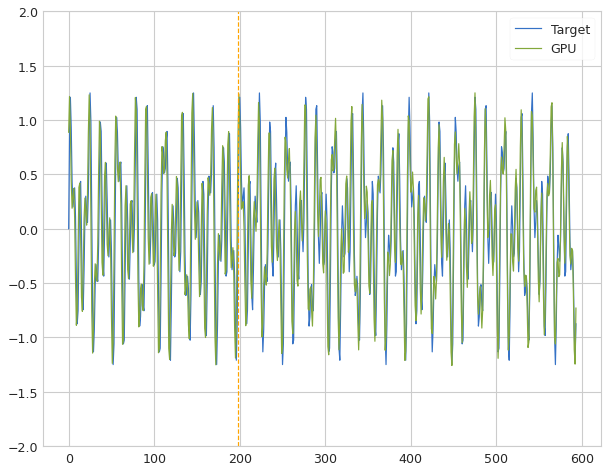

 Iter=98 a=0.766 sr=1.030 amp=0.813  ri=0.643 rr=3.072 loss=0.112243


Iter: 98 #### Diagnostic 0.112   Time 1.03  Best 0.112 NRMSE 0.112 CD 0.106
Iter: 99 #### Diagnostic 0.283   Time 0.98  Best 0.112 NRMSE 0.283 CD 1.113

Best result = 0.11224299043813085
a = 0.7664193812929324
sr = 1.029852873229127
amp = 0.8128804262686022
ri = 0.6434720218608068
rr = 3.0715178566614627

 ********** 300 ***********
Iter: 0 #### Diagnostic 0.312   Time 0.80  Best 1000.000 NRMSE 0.312 CD 0.944
Iter: 1 #### Diagnostic 0.329   Time 0.77  Best 1000.000 NRMSE 0.329 CD 0.987
Iter: 2 #### Diagnostic 0.244   Time 0.84  Best 1000.000 NRMSE 0.244 CD 0.877
Iter: 3 #### Diagnostic 0.266   Time 1.06  Best 1000.000 NRMSE 0.266 CD 1.081
Iter: 4 #### Diagnostic 0.249   Time 0.95  Best 1000.000 NRMSE 0.249 CD 0.939
Iter: 5 #### Diagnostic 0.255   Time 0.56  Best 1000.000 NRMSE 0.255 CD 0.958
Iter: 6 #### Diagnostic 0.247   Time 0.94  Best 1000.000 NRMSE 0.247 CD 1.000
Iter: 7 #### Diagnostic 0.333   Time 1.12  Best 

Iter: 99 #### Diagnostic 0.245   Time 1.69  Best 1000.000 NRMSE 0.245 CD 0.954

Best result = 0.15860753119998006
a = 0.8826284774087113
sr = 1.0641241070474894
amp = 0.8413433939678405
ri = 0.9533739241857593
rr = 4.4446422108373

Best mn:0.766	 mn:0.766
New bounds mn--mx: 0.242--0.008

Best mn:1.030	 mn:1.030
New bounds mn--mx: 0.234--0.216

Best mn:0.813	 mn:0.813
New bounds mn--mx: 0.202--0.173

Best mn:0.643	 mn:0.643
New bounds mn--mx: 0.163--0.211

Best mn:3.072	 mn:3.072
New bounds mn--mx: 0.591--1.283
Refined search bounds:

Alpha (0.5249184597694522, 0.7747934597694521)

Rho (0.7955575281249132, 1.2454325281249132)

Gamma (0.6111572407217207, 0.9860322407217207)

r-in (0.4799906791103995, 0.8548656791103996)

r-res (2.480030247835197, 4.354905247835196)

End Refinement Run 2 Time 366.525

 ********** 300 ***********
Iter: 0 #### Diagnostic 0.258   Time 0.55  Best 1000.000 NRMSE 0.258 CD 0.959
Iter: 1 #### Diagnostic 0.262   Time 0.70  Best 1000.000 NRMSE 0.262 CD 0.990
Iter: 

Iter: 94 #### Diagnostic 0.251   Time 0.51  Best 1000.000 NRMSE 0.251 CD 1.088
Iter: 95 #### Diagnostic 0.296   Time 0.32  Best 1000.000 NRMSE 0.296 CD 0.952
Iter: 96 #### Diagnostic 0.245   Time 0.40  Best 1000.000 NRMSE 0.245 CD 0.955
Iter: 97 #### Diagnostic 0.246   Time 0.81  Best 1000.000 NRMSE 0.246 CD 0.889
Iter: 98 #### Diagnostic 0.246   Time 0.62  Best 1000.000 NRMSE 0.246 CD 1.005
Iter: 99 #### Diagnostic 0.242   Time 0.72  Best 1000.000 NRMSE 0.242 CD 0.852

Best result = 0.16857408640760096
a = 0.9239260069229531
sr = 0.8133594227625056
amp = 0.9882685388537406
ri = 0.47017115480644184
rr = 4.117857163090081

 ********** 300 ***********
Iter: 0 #### Diagnostic 0.296   Time 0.90  Best 1000.000 NRMSE 0.296 CD 1.079
Iter: 1 #### Diagnostic 0.246   Time 1.11  Best 1000.000 NRMSE 0.246 CD 0.905
Iter: 2 #### Diagnostic 0.242   Time 0.43  Best 1000.000 NRMSE 0.242 CD 0.833
Iter: 3 #### Diagnostic 0.359   Time 0.66  Best 1000.000 NRMSE 0.359 CD 0.971
Iter: 4 #### Diagnostic 0.237 

Iter: 96 #### Diagnostic 0.246   Time 0.80  Best 1000.000 NRMSE 0.246 CD 1.011
Iter: 97 #### Diagnostic 0.244   Time 1.00  Best 1000.000 NRMSE 0.244 CD 0.874
Iter: 98 #### Diagnostic 0.312   Time 0.89  Best 1000.000 NRMSE 0.312 CD 1.008
Iter: 99 #### Diagnostic 0.245   Time 0.47  Best 1000.000 NRMSE 0.245 CD 0.936

Best result = 0.15727209857278387
a = 0.6976017796932442
sr = 1.008546773155393
amp = 0.8974153185899203
ri = 0.10776965340100186
rr = 0.06285035434835733

 ********** 300 ***********
Iter: 0 #### Diagnostic 0.244   Time 0.53  Best 1000.000 NRMSE 0.244 CD 0.885
Iter: 1 #### Diagnostic 0.244   Time 0.91  Best 1000.000 NRMSE 0.244 CD 0.877
Iter: 2 #### Diagnostic 0.244   Time 0.97  Best 1000.000 NRMSE 0.244 CD 0.883
Iter: 3 #### Diagnostic 0.166   Time 0.90  Best 1000.000 NRMSE 0.166 CD 0.239
Iter: 4 #### Diagnostic 0.304   Time 0.85  Best 1000.000 NRMSE 0.304 CD 1.097
Iter: 5 #### Diagnostic 0.360   Time 1.02  Best 1000.000 NRMSE 0.360 CD 0.996
Iter: 6 #### Diagnostic 0.230  

Iter: 98 #### Diagnostic 0.292   Time 1.06  Best 1000.000 NRMSE 0.292 CD 0.915
Iter: 99 #### Diagnostic 0.296   Time 0.88  Best 1000.000 NRMSE 0.296 CD 1.001

Best result = 0.16596563735311334
a = 0.9133881442767227
sr = 0.9192258277689374
amp = 0.9736746186688038
ri = 0.4029582829153992
rr = 2.7643069800014937

 ********** 300 ***********
Iter: 0 #### Diagnostic 0.243   Time 0.50  Best 1000.000 NRMSE 0.243 CD 0.873
Iter: 1 #### Diagnostic 0.276   Time 0.54  Best 1000.000 NRMSE 0.276 CD 0.915
Iter: 2 #### Diagnostic 0.253   Time 0.61  Best 1000.000 NRMSE 0.253 CD 0.930
Iter: 3 #### Diagnostic 0.267   Time 0.62  Best 1000.000 NRMSE 0.267 CD 0.885
Iter: 4 #### Diagnostic 0.249   Time 1.32  Best 1000.000 NRMSE 0.249 CD 0.931
Iter: 5 #### Diagnostic 0.204   Time 1.15  Best 1000.000 NRMSE 0.204 CD 0.351
Iter: 6 #### Diagnostic 0.242   Time 1.05  Best 1000.000 NRMSE 0.242 CD 0.840
Iter: 7 #### Diagnostic 0.243   Time 0.95  Best 1000.000 NRMSE 0.243 CD 0.864
Iter: 8 #### Diagnostic 0.245   Ti


Best result = 0.14350054831461304
a = 0.7664193812929324
sr = 1.029852873229127
amp = 0.8128804262686022
ri = 0.6434720218608068
rr = 3.0715178566614627

 ********** 300 ***********
Iter: 0 #### Diagnostic 0.292   Time 0.92  Best 1000.000 NRMSE 0.292 CD 0.897
Iter: 1 #### Diagnostic 0.264   Time 0.86  Best 1000.000 NRMSE 0.264 CD 0.978
Iter: 2 #### Diagnostic 0.243   Time 0.77  Best 1000.000 NRMSE 0.243 CD 0.863
Iter: 3 #### Diagnostic 0.252   Time 0.60  Best 1000.000 NRMSE 0.252 CD 0.955
Iter: 4 #### Diagnostic 0.247   Time 0.69  Best 1000.000 NRMSE 0.247 CD 0.926
Iter: 5 #### Diagnostic 0.253   Time 0.45  Best 1000.000 NRMSE 0.253 CD 0.945
Iter: 6 #### Diagnostic 0.247   Time 0.53  Best 1000.000 NRMSE 0.247 CD 0.993
Iter: 7 #### Diagnostic 0.322   Time 0.95  Best 1000.000 NRMSE 0.322 CD 1.039
Iter: 8 #### Diagnostic 0.243   Time 1.09  Best 1000.000 NRMSE 0.243 CD 0.860
Iter: 9 #### Diagnostic 1000.000   Time 1.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 0.246   

Iter: 0 #### Diagnostic 0.247   Time 1.20  Best 1000.000 NRMSE 0.247 CD 0.924
Iter: 1 #### Diagnostic 0.267   Time 1.16  Best 1000.000 NRMSE 0.267 CD 0.993
Iter: 2 #### Diagnostic 1000.000   Time 0.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 0.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 0.246   Time 0.64  Best 1000.000 NRMSE 0.246 CD 0.962
Iter: 5 #### Diagnostic 0.319   Time 0.62  Best 1000.000 NRMSE 0.319 CD 1.138
Iter: 6 #### Diagnostic 0.258   Time 0.81  Best 1000.000 NRMSE 0.258 CD 0.969
Iter: 7 #### Diagnostic 0.269   Time 0.73  Best 1000.000 NRMSE 0.269 CD 0.979
Iter: 8 #### Diagnostic 0.244   Time 0.65  Best 1000.000 NRMSE 0.244 CD 0.883
Iter: 9 #### Diagnostic 0.189   Time 0.81  Best 1000.000 NRMSE 0.189 CD 0.305
Iter: 10 #### Diagnostic 0.249   Time 0.67  Best 1000.000 NRMSE 0.249 CD 0.938
Iter: 11 #### Diagnostic 0.410   Time 1.23  Best 1000.000 NRMSE 0.410 CD 0.989
Iter: 12 #### Diagnostic 0.283   Time 1.00  Best 1000.

Iter: 2 #### Diagnostic 0.244   Time 0.44  Best 1000.000 NRMSE 0.244 CD 0.905
Iter: 3 #### Diagnostic 0.310   Time 0.69  Best 1000.000 NRMSE 0.310 CD 0.922
Iter: 4 #### Diagnostic 0.316   Time 0.58  Best 1000.000 NRMSE 0.316 CD 1.129
Iter: 5 #### Diagnostic 0.257   Time 1.17  Best 1000.000 NRMSE 0.257 CD 0.940
Iter: 6 #### Diagnostic 0.314   Time 0.71  Best 1000.000 NRMSE 0.314 CD 1.002
Iter: 7 #### Diagnostic 0.243   Time 0.49  Best 1000.000 NRMSE 0.243 CD 0.872
Iter: 8 #### Diagnostic 0.247   Time 0.56  Best 1000.000 NRMSE 0.247 CD 0.935
Iter: 9 #### Diagnostic 0.275   Time 1.35  Best 1000.000 NRMSE 0.275 CD 1.013
Iter: 10 #### Diagnostic 0.244   Time 1.44  Best 1000.000 NRMSE 0.244 CD 0.891
Iter: 11 #### Diagnostic 0.371   Time 1.06  Best 1000.000 NRMSE 0.371 CD 1.030
Iter: 12 #### Diagnostic 0.244   Time 0.94  Best 1000.000 NRMSE 0.244 CD 0.902
Iter: 13 #### Diagnostic 0.246   Time 1.06  Best 1000.000 NRMSE 0.246 CD 1.011
Iter: 14 #### Diagnostic 0.243   Time 0.86  Best 1000.000 NR

Iter: 4 #### Diagnostic 0.355   Time 1.12  Best 1000.000 NRMSE 0.355 CD 1.054
Iter: 5 #### Diagnostic 0.308   Time 1.29  Best 1000.000 NRMSE 0.308 CD 0.946
Iter: 6 #### Diagnostic 0.220   Time 0.85  Best 1000.000 NRMSE 0.220 CD 0.543
Iter: 7 #### Diagnostic 0.264   Time 0.40  Best 1000.000 NRMSE 0.264 CD 0.996
Iter: 8 #### Diagnostic 0.255   Time 0.46  Best 1000.000 NRMSE 0.255 CD 0.965
Iter: 9 #### Diagnostic 0.286   Time 0.36  Best 1000.000 NRMSE 0.286 CD 0.354
Iter: 10 #### Diagnostic 0.246   Time 0.90  Best 1000.000 NRMSE 0.246 CD 1.004
Iter: 11 #### Diagnostic 0.305   Time 0.80  Best 1000.000 NRMSE 0.305 CD 1.042
Iter: 12 #### Diagnostic 0.308   Time 0.86  Best 1000.000 NRMSE 0.308 CD 0.984
Iter: 13 #### Diagnostic 0.252   Time 0.71  Best 1000.000 NRMSE 0.252 CD 0.956
Iter: 14 #### Diagnostic 0.245   Time 0.75  Best 1000.000 NRMSE 0.245 CD 0.942
Iter: 15 #### Diagnostic 0.292   Time 0.76  Best 1000.000 NRMSE 0.292 CD 0.996
Iter: 16 #### Diagnostic 0.246   Time 0.77  Best 1000.000 

Iter: 6 #### Diagnostic 0.244   Time 1.12  Best 1000.000 NRMSE 0.244 CD 0.865
Iter: 7 #### Diagnostic 0.243   Time 0.92  Best 1000.000 NRMSE 0.243 CD 0.861
Iter: 8 #### Diagnostic 0.247   Time 1.07  Best 1000.000 NRMSE 0.247 CD 0.899
Iter: 9 #### Diagnostic 0.245   Time 0.72  Best 1000.000 NRMSE 0.245 CD 0.928
Iter: 10 #### Diagnostic 0.243   Time 0.53  Best 1000.000 NRMSE 0.243 CD 0.876
Iter: 11 #### Diagnostic 0.286   Time 0.49  Best 1000.000 NRMSE 0.286 CD 1.036
Iter: 12 #### Diagnostic 0.254   Time 0.73  Best 1000.000 NRMSE 0.254 CD 0.968
Iter: 13 #### Diagnostic 0.243   Time 0.46  Best 1000.000 NRMSE 0.243 CD 0.856
Iter: 14 #### Diagnostic 0.243   Time 0.58  Best 1000.000 NRMSE 0.243 CD 0.793
Iter: 15 #### Diagnostic 0.244   Time 0.97  Best 1000.000 NRMSE 0.244 CD 0.900
Iter: 16 #### Diagnostic 0.254   Time 0.64  Best 1000.000 NRMSE 0.254 CD 0.871
Iter: 17 #### Diagnostic 0.328   Time 0.83  Best 1000.000 NRMSE 0.328 CD 1.046
Iter: 18 #### Diagnostic 0.246   Time 0.88  Best 1000.00

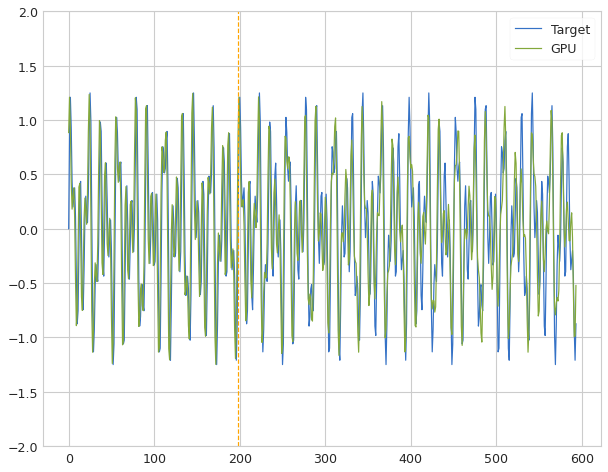

 Iter=98 a=0.766 sr=1.030 amp=0.813  ri=0.643 rr=3.072 loss=0.136547


Iter: 98 #### Diagnostic 0.137   Time 1.08  Best 0.137 NRMSE 0.137 CD 0.166
Iter: 99 #### Diagnostic 0.322   Time 0.65  Best 0.137 NRMSE 0.322 CD 0.984

Best result = 0.13654724368175383
a = 0.7664193812929324
sr = 1.029852873229127
amp = 0.8128804262686022
ri = 0.6434720218608068
rr = 3.0715178566614627

 ********** 300 ***********
Iter: 0 #### Diagnostic 0.319   Time 0.66  Best 1000.000 NRMSE 0.319 CD 0.976
Iter: 1 #### Diagnostic 0.371   Time 0.83  Best 1000.000 NRMSE 0.371 CD 0.988
Iter: 2 #### Diagnostic 0.247   Time 0.83  Best 1000.000 NRMSE 0.247 CD 0.916
Iter: 3 #### Diagnostic 0.237   Time 0.68  Best 1000.000 NRMSE 0.237 CD 0.751
Iter: 4 #### Diagnostic 0.250   Time 0.73  Best 1000.000 NRMSE 0.250 CD 0.944
Iter: 5 #### Diagnostic 0.251   Time 0.40  Best 1000.000 NRMSE 0.251 CD 0.930
Iter: 6 #### Diagnostic 0.247   Time 0.25  Best 1000.000 NRMSE 0.247 CD 1.004
Iter: 7 #### Diagnostic 0.320   Time 0.29  Best 

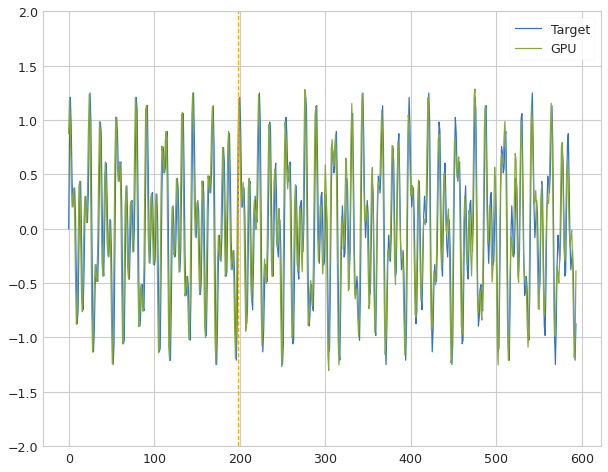

 Iter=63 a=0.883 sr=1.064 amp=0.841  ri=0.953 rr=4.445 loss=0.136074


Iter: 63 #### Diagnostic 0.136   Time 1.19  Best 0.136 NRMSE 0.136 CD 0.156
Iter: 64 #### Diagnostic 0.282   Time 0.82  Best 0.136 NRMSE 0.282 CD 0.897
Iter: 65 #### Diagnostic 0.246   Time 0.66  Best 0.136 NRMSE 0.246 CD 0.972
Iter: 66 #### Diagnostic 0.291   Time 0.54  Best 0.136 NRMSE 0.291 CD 0.956
Iter: 67 #### Diagnostic 0.300   Time 0.55  Best 0.136 NRMSE 0.300 CD 1.019
Iter: 68 #### Diagnostic 0.255   Time 0.81  Best 0.136 NRMSE 0.255 CD 0.974
Iter: 69 #### Diagnostic 0.310   Time 0.69  Best 0.136 NRMSE 0.310 CD 0.956
Iter: 70 #### Diagnostic 0.238   Time 0.49  Best 0.136 NRMSE 0.238 CD 0.765
Iter: 71 #### Diagnostic 0.294   Time 0.58  Best 0.136 NRMSE 0.294 CD 0.956
Iter: 72 #### Diagnostic 0.293   Time 0.48  Best 0.136 NRMSE 0.293 CD 0.951
Iter: 73 #### Diagnostic 0.246   Time 0.28  Best 0.136 NRMSE 0.246 CD 1.020
Iter: 74 #### Diagnostic 0.246   Time 0.31  Best 0.136 NRMSE 0.246 CD 1.002
Iter: 75 #### Dia

Iter: 58 #### Diagnostic 0.396   Time 0.27  Best 1000.000 NRMSE 0.396 CD 0.999
Iter: 59 #### Diagnostic 0.313   Time 0.36  Best 1000.000 NRMSE 0.313 CD 1.002
Iter: 60 #### Diagnostic 0.265   Time 0.49  Best 1000.000 NRMSE 0.265 CD 0.998
Iter: 61 #### Diagnostic 0.322   Time 0.65  Best 1000.000 NRMSE 0.322 CD 1.003
Iter: 62 #### Diagnostic 0.246   Time 0.56  Best 1000.000 NRMSE 0.246 CD 0.990
Iter: 63 #### Diagnostic 0.246   Time 0.67  Best 1000.000 NRMSE 0.246 CD 0.927
Iter: 64 #### Diagnostic 0.249   Time 0.65  Best 1000.000 NRMSE 0.249 CD 0.929
Iter: 65 #### Diagnostic 0.243   Time 0.69  Best 1000.000 NRMSE 0.243 CD 0.865
Iter: 66 #### Diagnostic 0.246   Time 0.64  Best 1000.000 NRMSE 0.246 CD 0.902
Iter: 67 #### Diagnostic 0.247   Time 0.69  Best 1000.000 NRMSE 0.247 CD 1.000
Iter: 68 #### Diagnostic 0.247   Time 0.57  Best 1000.000 NRMSE 0.247 CD 1.017
Iter: 69 #### Diagnostic 0.243   Time 0.70  Best 1000.000 NRMSE 0.243 CD 0.882
Iter: 70 #### Diagnostic 0.242   Time 0.60  Best 100

Iter: 60 #### Diagnostic 0.242   Time 0.71  Best 1000.000 NRMSE 0.242 CD 0.834
Iter: 61 #### Diagnostic 0.331   Time 0.66  Best 1000.000 NRMSE 0.331 CD 1.036
Iter: 62 #### Diagnostic 0.245   Time 0.60  Best 1000.000 NRMSE 0.245 CD 0.992
Iter: 63 #### Diagnostic 0.243   Time 0.43  Best 1000.000 NRMSE 0.243 CD 0.874
Iter: 64 #### Diagnostic 0.337   Time 0.39  Best 1000.000 NRMSE 0.337 CD 0.969
Iter: 65 #### Diagnostic 0.252   Time 0.40  Best 1000.000 NRMSE 0.252 CD 0.947
Iter: 66 #### Diagnostic 0.243   Time 0.48  Best 1000.000 NRMSE 0.243 CD 0.876
Iter: 67 #### Diagnostic 0.311   Time 0.51  Best 1000.000 NRMSE 0.311 CD 1.213
Iter: 68 #### Diagnostic 0.244   Time 0.43  Best 1000.000 NRMSE 0.244 CD 0.884
Iter: 69 #### Diagnostic 0.244   Time 0.56  Best 1000.000 NRMSE 0.244 CD 0.884
Iter: 70 #### Diagnostic 0.360   Time 0.92  Best 1000.000 NRMSE 0.360 CD 0.981
Iter: 71 #### Diagnostic 0.240   Time 0.65  Best 1000.000 NRMSE 0.240 CD 0.788
Iter: 72 #### Diagnostic 0.247   Time 0.54  Best 100

Iter: 62 #### Diagnostic 0.254   Time 0.41  Best 1000.000 NRMSE 0.254 CD 0.963
Iter: 63 #### Diagnostic 0.247   Time 0.56  Best 1000.000 NRMSE 0.247 CD 1.028
Iter: 64 #### Diagnostic 1000.000   Time 0.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 0.312   Time 0.48  Best 1000.000 NRMSE 0.312 CD 0.967
Iter: 66 #### Diagnostic 0.250   Time 0.42  Best 1000.000 NRMSE 0.250 CD 0.976
Iter: 67 #### Diagnostic 0.247   Time 0.47  Best 1000.000 NRMSE 0.247 CD 1.005
Iter: 68 #### Diagnostic 0.269   Time 0.68  Best 1000.000 NRMSE 0.269 CD 0.979
Iter: 69 #### Diagnostic 0.246   Time 0.54  Best 1000.000 NRMSE 0.246 CD 0.999
Iter: 70 #### Diagnostic 0.246   Time 0.41  Best 1000.000 NRMSE 0.246 CD 0.971
Iter: 71 #### Diagnostic 0.261   Time 0.41  Best 1000.000 NRMSE 0.261 CD 0.966
Iter: 72 #### Diagnostic 0.246   Time 0.36  Best 1000.000 NRMSE 0.246 CD 0.959
Iter: 73 #### Diagnostic 0.246   Time 0.23  Best 1000.000 NRMSE 0.246 CD 0.988
Iter: 74 #### Diagnostic 0.244   Time 0.25  Best

Iter: 64 #### Diagnostic 0.279   Time 0.69  Best 1000.000 NRMSE 0.279 CD 0.990
Iter: 65 #### Diagnostic 0.245   Time 0.57  Best 1000.000 NRMSE 0.245 CD 0.924
Iter: 66 #### Diagnostic 0.244   Time 0.57  Best 1000.000 NRMSE 0.244 CD 0.882
Iter: 67 #### Diagnostic 0.244   Time 0.58  Best 1000.000 NRMSE 0.244 CD 0.895
Iter: 68 #### Diagnostic 0.809   Time 0.30  Best 1000.000 NRMSE 0.809 CD 1.084
Iter: 69 #### Diagnostic 0.247   Time 0.71  Best 1000.000 NRMSE 0.247 CD 0.925
Iter: 70 #### Diagnostic 0.246   Time 0.61  Best 1000.000 NRMSE 0.246 CD 0.964
Iter: 71 #### Diagnostic 0.262   Time 0.45  Best 1000.000 NRMSE 0.262 CD 0.999
Iter: 72 #### Diagnostic 0.356   Time 0.69  Best 1000.000 NRMSE 0.356 CD 0.998
Iter: 73 #### Diagnostic 0.255   Time 0.56  Best 1000.000 NRMSE 0.255 CD 0.957
Iter: 74 #### Diagnostic 0.279   Time 0.60  Best 1000.000 NRMSE 0.279 CD 0.935
Iter: 75 #### Diagnostic 0.261   Time 0.60  Best 1000.000 NRMSE 0.261 CD 0.896
Iter: 76 #### Diagnostic 0.288   Time 1.11  Best 100

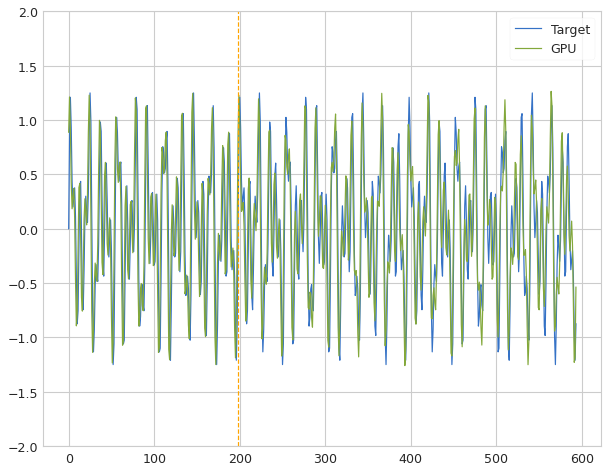

 Iter=98 a=0.766 sr=1.030 amp=0.813  ri=0.643 rr=3.072 loss=0.129083


Iter: 98 #### Diagnostic 0.129   Time 0.92  Best 0.129 NRMSE 0.129 CD 0.143
Iter: 99 #### Diagnostic 0.241   Time 0.62  Best 0.129 NRMSE 0.241 CD 0.818

Best result = 0.12908300001946596
a = 0.7664193812929324
sr = 1.029852873229127
amp = 0.8128804262686022
ri = 0.6434720218608068
rr = 3.0715178566614627

 ********** 200 ***********
Iter: 0 #### Diagnostic 0.295   Time 0.51  Best 1000.000 NRMSE 0.295 CD 0.989
Iter: 1 #### Diagnostic 0.257   Time 0.22  Best 1000.000 NRMSE 0.257 CD 0.965
Iter: 2 #### Diagnostic 0.243   Time 0.41  Best 1000.000 NRMSE 0.243 CD 0.859
Iter: 3 #### Diagnostic 0.258   Time 0.47  Best 1000.000 NRMSE 0.258 CD 1.039
Iter: 4 #### Diagnostic 0.247   Time 0.59  Best 1000.000 NRMSE 0.247 CD 0.932
Iter: 5 #### Diagnostic 0.269   Time 0.61  Best 1000.000 NRMSE 0.269 CD 0.980
Iter: 6 #### Diagnostic 0.247   Time 0.47  Best 1000.000 NRMSE 0.247 CD 1.001
Iter: 7 #### Diagnostic 0.239   Time 0.57  Best 

Iter: 99 #### Diagnostic 0.244   Time 0.51  Best 1000.000 NRMSE 0.244 CD 0.898

Best result = 0.16490616019775342
a = 0.8376748276336698
sr = 1.0773913981365761
amp = 0.8022424114082842
ri = 0.27930776562889753
rr = 1.4202708501582084

Best mn:0.766	 mn:0.766
New bounds mn--mx: 0.383--0.117

Best mn:1.030	 mn:1.030
New bounds mn--mx: 0.514--0.085

Best mn:0.813	 mn:0.813
New bounds mn--mx: 0.406--0.094

Best mn:0.643	 mn:0.643
New bounds mn--mx: 0.321--0.178

Best mn:3.072	 mn:3.072
New bounds mn--mx: 1.535--0.964
Refined search bounds:

Alpha (0.3837096906464662, 0.8832096906464662)

Rho (0.5154264366145634, 1.1149264366145635)

Gamma (0.4069402131343011, 0.9064402131343011)

r-in (0.3222360109304034, 0.8217360109304034)

r-res (1.5362589283307313, 4.035758928330731)

End Refinement Run 0 Time 267.056

 ********** 200 ***********
Iter: 0 #### Diagnostic 0.246   Time 0.49  Best 1000.000 NRMSE 0.246 CD 0.914
Iter: 1 #### Diagnostic 0.257   Time 0.70  Best 1000.000 NRMSE 0.257 CD 0.943
I

Iter: 93 #### Diagnostic 0.246   Time 0.58  Best 1000.000 NRMSE 0.246 CD 0.999
Iter: 94 #### Diagnostic 0.247   Time 0.35  Best 1000.000 NRMSE 0.247 CD 1.105
Iter: 95 #### Diagnostic 0.323   Time 0.41  Best 1000.000 NRMSE 0.323 CD 0.964
Iter: 96 #### Diagnostic 0.246   Time 0.64  Best 1000.000 NRMSE 0.246 CD 0.984
Iter: 97 #### Diagnostic 0.322   Time 0.70  Best 1000.000 NRMSE 0.322 CD 1.051
Iter: 98 #### Diagnostic 0.246   Time 1.17  Best 1000.000 NRMSE 0.246 CD 1.005
Iter: 99 #### Diagnostic 0.242   Time 1.13  Best 1000.000 NRMSE 0.242 CD 0.841

Best result = 0.14263527756796962
a = 0.9239260069229531
sr = 0.8133594227625056
amp = 0.9882685388537406
ri = 0.47017115480644184
rr = 4.117857163090081

 ********** 200 ***********
Iter: 0 #### Diagnostic 0.272   Time 0.61  Best 1000.000 NRMSE 0.272 CD 1.033
Iter: 1 #### Diagnostic 0.257   Time 1.04  Best 1000.000 NRMSE 0.257 CD 0.963
Iter: 2 #### Diagnostic 0.246   Time 0.63  Best 1000.000 NRMSE 0.246 CD 0.952
Iter: 3 #### Diagnostic 0.479

Iter: 95 #### Diagnostic 0.243   Time 0.64  Best 1000.000 NRMSE 0.243 CD 0.861
Iter: 96 #### Diagnostic 0.246   Time 0.58  Best 1000.000 NRMSE 0.246 CD 1.006
Iter: 97 #### Diagnostic 0.246   Time 0.62  Best 1000.000 NRMSE 0.246 CD 0.891
Iter: 98 #### Diagnostic 0.392   Time 0.48  Best 1000.000 NRMSE 0.392 CD 1.009
Iter: 99 #### Diagnostic 0.244   Time 0.46  Best 1000.000 NRMSE 0.244 CD 0.923

Best result = 0.21022563981792558
a = 0.1493509420606155
sr = 1.1731576844227807
amp = 0.6848876415800057
ri = 0.8650383178137911
rr = 0.34004093028878163

 ********** 200 ***********
Iter: 0 #### Diagnostic 1000.000   Time 0.75  Best 1000.000 NRMSE 166713.106 CD 1.097
Iter: 1 #### Diagnostic 0.246   Time 0.62  Best 1000.000 NRMSE 0.246 CD 0.903
Iter: 2 #### Diagnostic 0.245   Time 0.71  Best 1000.000 NRMSE 0.245 CD 0.901
Iter: 3 #### Diagnostic 0.151   Time 0.50  Best 1000.000 NRMSE 0.151 CD 0.197
Iter: 4 #### Diagnostic 0.327   Time 0.60  Best 1000.000 NRMSE 0.327 CD 1.027
Iter: 5 #### Diagnosti

Iter: 97 #### Diagnostic 0.593   Time 0.96  Best 1000.000 NRMSE 0.593 CD 1.002
Iter: 98 #### Diagnostic 0.272   Time 0.52  Best 1000.000 NRMSE 0.272 CD 0.893
Iter: 99 #### Diagnostic 0.272   Time 0.58  Best 1000.000 NRMSE 0.272 CD 1.062

Best result = 0.15121265726546962
a = 0.9133881442767227
sr = 0.9192258277689374
amp = 0.9736746186688038
ri = 0.4029582829153992
rr = 2.7643069800014937

 ********** 200 ***********
Iter: 0 #### Diagnostic 0.245   Time 0.74  Best 1000.000 NRMSE 0.245 CD 0.913
Iter: 1 #### Diagnostic 0.266   Time 0.54  Best 1000.000 NRMSE 0.266 CD 0.956
Iter: 2 #### Diagnostic 0.243   Time 0.50  Best 1000.000 NRMSE 0.243 CD 0.868
Iter: 3 #### Diagnostic 0.326   Time 0.54  Best 1000.000 NRMSE 0.326 CD 1.173
Iter: 4 #### Diagnostic 0.250   Time 0.26  Best 1000.000 NRMSE 0.250 CD 0.945
Iter: 5 #### Diagnostic 0.742   Time 0.40  Best 1000.000 NRMSE 0.742 CD 0.486
Iter: 6 #### Diagnostic 0.243   Time 0.95  Best 1000.000 NRMSE 0.243 CD 0.860
Iter: 7 #### Diagnostic 0.244   T

Iter: 99 #### Diagnostic 0.253   Time 0.46  Best 1000.000 NRMSE 0.253 CD 0.954

Best result = 0.17895989140976273
a = 0.5988647800103952
sr = 1.0461601712040611
amp = 0.9304339509181757
ri = 0.18036720998227512
rr = 1.831122495098401

 ********** 200 ***********
Iter: 0 #### Diagnostic 0.280   Time 0.58  Best 1000.000 NRMSE 0.280 CD 0.845
Iter: 1 #### Diagnostic 0.251   Time 0.81  Best 1000.000 NRMSE 0.251 CD 0.943
Iter: 2 #### Diagnostic 0.244   Time 0.91  Best 1000.000 NRMSE 0.244 CD 0.880
Iter: 3 #### Diagnostic 0.237   Time 0.51  Best 1000.000 NRMSE 0.237 CD 0.745
Iter: 4 #### Diagnostic 0.249   Time 0.62  Best 1000.000 NRMSE 0.249 CD 0.938
Iter: 5 #### Diagnostic 0.253   Time 0.92  Best 1000.000 NRMSE 0.253 CD 0.953
Iter: 6 #### Diagnostic 0.247   Time 0.71  Best 1000.000 NRMSE 0.247 CD 0.998
Iter: 7 #### Diagnostic 0.329   Time 0.78  Best 1000.000 NRMSE 0.329 CD 1.142
Iter: 8 #### Diagnostic 0.243   Time 0.65  Best 1000.000 NRMSE 0.243 CD 0.885
Iter: 9 #### Diagnostic 1000.000   

Iter: 0 #### Diagnostic 0.249   Time 0.42  Best 1000.000 NRMSE 0.249 CD 0.939
Iter: 1 #### Diagnostic 0.260   Time 0.48  Best 1000.000 NRMSE 0.260 CD 0.985
Iter: 2 #### Diagnostic 0.254   Time 0.71  Best 1000.000 NRMSE 0.254 CD 0.942
Iter: 3 #### Diagnostic 1.495   Time 0.70  Best 1000.000 NRMSE 1.495 CD 0.975
Iter: 4 #### Diagnostic 0.245   Time 0.39  Best 1000.000 NRMSE 0.245 CD 0.933
Iter: 5 #### Diagnostic 0.330   Time 0.48  Best 1000.000 NRMSE 0.330 CD 1.176
Iter: 6 #### Diagnostic 0.292   Time 0.44  Best 1000.000 NRMSE 0.292 CD 0.986
Iter: 7 #### Diagnostic 0.325   Time 0.50  Best 1000.000 NRMSE 0.325 CD 1.005
Iter: 8 #### Diagnostic 0.244   Time 0.54  Best 1000.000 NRMSE 0.244 CD 0.883
Iter: 9 #### Diagnostic 0.172   Time 0.61  Best 1000.000 NRMSE 0.172 CD 0.253
Iter: 10 #### Diagnostic 0.250   Time 0.64  Best 1000.000 NRMSE 0.250 CD 0.940
Iter: 11 #### Diagnostic 0.338   Time 0.48  Best 1000.000 NRMSE 0.338 CD 0.980
Iter: 12 #### Diagnostic 0.260   Time 0.36  Best 1000.000 NRMS

Iter: 2 #### Diagnostic 0.243   Time 0.81  Best 1000.000 NRMSE 0.243 CD 0.884
Iter: 3 #### Diagnostic 0.241   Time 0.57  Best 1000.000 NRMSE 0.241 CD 0.817
Iter: 4 #### Diagnostic 0.304   Time 0.25  Best 1000.000 NRMSE 0.304 CD 0.983
Iter: 5 #### Diagnostic 0.449   Time 0.33  Best 1000.000 NRMSE 0.449 CD 1.001
Iter: 6 #### Diagnostic 0.256   Time 0.24  Best 1000.000 NRMSE 0.256 CD 0.957
Iter: 7 #### Diagnostic 0.243   Time 0.23  Best 1000.000 NRMSE 0.243 CD 0.864
Iter: 8 #### Diagnostic 0.246   Time 0.22  Best 1000.000 NRMSE 0.246 CD 0.903
Iter: 9 #### Diagnostic 0.247   Time 0.22  Best 1000.000 NRMSE 0.247 CD 0.837
Iter: 10 #### Diagnostic 0.249   Time 0.23  Best 1000.000 NRMSE 0.249 CD 0.937
Iter: 11 #### Diagnostic 0.244   Time 0.38  Best 1000.000 NRMSE 0.244 CD 0.890
Iter: 12 #### Diagnostic 0.243   Time 0.46  Best 1000.000 NRMSE 0.243 CD 0.876
Iter: 13 #### Diagnostic 0.246   Time 0.53  Best 1000.000 NRMSE 0.246 CD 1.009
Iter: 14 #### Diagnostic 0.243   Time 0.28  Best 1000.000 NR

Iter: 4 #### Diagnostic 0.326   Time 0.60  Best 1000.000 NRMSE 0.326 CD 0.966
Iter: 5 #### Diagnostic 0.348   Time 0.49  Best 1000.000 NRMSE 0.348 CD 0.992
Iter: 6 #### Diagnostic 0.257   Time 0.49  Best 1000.000 NRMSE 0.257 CD 0.974
Iter: 7 #### Diagnostic 0.256   Time 0.45  Best 1000.000 NRMSE 0.256 CD 0.970
Iter: 8 #### Diagnostic 0.252   Time 0.51  Best 1000.000 NRMSE 0.252 CD 0.955
Iter: 9 #### Diagnostic 0.255   Time 0.52  Best 1000.000 NRMSE 0.255 CD 0.505
Iter: 10 #### Diagnostic 0.246   Time 0.46  Best 1000.000 NRMSE 0.246 CD 1.002
Iter: 11 #### Diagnostic 0.304   Time 0.43  Best 1000.000 NRMSE 0.304 CD 0.961
Iter: 12 #### Diagnostic 0.312   Time 0.60  Best 1000.000 NRMSE 0.312 CD 0.958
Iter: 13 #### Diagnostic 1000.000   Time 0.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 0.247   Time 0.78  Best 1000.000 NRMSE 0.247 CD 0.988
Iter: 15 #### Diagnostic 0.244   Time 0.56  Best 1000.000 NRMSE 0.244 CD 0.888
Iter: 16 #### Diagnostic 0.246   Time 0.64  Best 1000.

Iter: 6 #### Diagnostic 0.254   Time 0.66  Best 1000.000 NRMSE 0.254 CD 0.954
Iter: 7 #### Diagnostic 0.243   Time 0.74  Best 1000.000 NRMSE 0.243 CD 0.873
Iter: 8 #### Diagnostic 0.242   Time 0.60  Best 1000.000 NRMSE 0.242 CD 0.828
Iter: 9 #### Diagnostic 0.246   Time 0.68  Best 1000.000 NRMSE 0.246 CD 0.996
Iter: 10 #### Diagnostic 0.243   Time 0.47  Best 1000.000 NRMSE 0.243 CD 0.873
Iter: 11 #### Diagnostic 0.265   Time 0.60  Best 1000.000 NRMSE 0.265 CD 1.007
Iter: 12 #### Diagnostic 0.242   Time 0.64  Best 1000.000 NRMSE 0.242 CD 0.841
Iter: 13 #### Diagnostic 0.245   Time 0.67  Best 1000.000 NRMSE 0.245 CD 0.896
Iter: 14 #### Diagnostic 0.240   Time 0.53  Best 1000.000 NRMSE 0.240 CD 0.793
Iter: 15 #### Diagnostic 0.246   Time 0.38  Best 1000.000 NRMSE 0.246 CD 1.009
Iter: 16 #### Diagnostic 0.256   Time 0.39  Best 1000.000 NRMSE 0.256 CD 0.955
Iter: 17 #### Diagnostic 0.319   Time 0.49  Best 1000.000 NRMSE 0.319 CD 0.970
Iter: 18 #### Diagnostic 0.245   Time 0.53  Best 1000.00

Iter: 8 #### Diagnostic 0.242   Time 0.43  Best 1000.000 NRMSE 0.242 CD 0.841
Iter: 9 #### Diagnostic 0.356   Time 0.59  Best 1000.000 NRMSE 0.356 CD 0.996
Iter: 10 #### Diagnostic 0.245   Time 0.39  Best 1000.000 NRMSE 0.245 CD 0.946
Iter: 11 #### Diagnostic 0.243   Time 0.78  Best 1000.000 NRMSE 0.243 CD 0.863
Iter: 12 #### Diagnostic 2.834   Time 0.74  Best 1000.000 NRMSE 2.834 CD 0.990
Iter: 13 #### Diagnostic 0.248   Time 0.59  Best 1000.000 NRMSE 0.248 CD 0.912
Iter: 14 #### Diagnostic 0.301   Time 0.66  Best 1000.000 NRMSE 0.301 CD 1.077
Iter: 15 #### Diagnostic 0.175   Time 0.93  Best 1000.000 NRMSE 0.175 CD 0.253
Iter: 16 #### Diagnostic 0.267   Time 0.57  Best 1000.000 NRMSE 0.267 CD 0.993
Iter: 17 #### Diagnostic 0.312   Time 0.60  Best 1000.000 NRMSE 0.312 CD 0.965
Iter: 18 #### Diagnostic 0.250   Time 0.84  Best 1000.000 NRMSE 0.250 CD 0.944
Iter: 19 #### Diagnostic 0.299   Time 0.68  Best 1000.000 NRMSE 0.299 CD 0.940
Iter: 20 #### Diagnostic 0.254   Time 0.65  Best 1000.

Iter: 6 #### Diagnostic 0.298   Time 0.22  Best 1000.000 NRMSE 0.298 CD 0.986
Iter: 7 #### Diagnostic 0.320   Time 0.23  Best 1000.000 NRMSE 0.320 CD 0.975
Iter: 8 #### Diagnostic 0.246   Time 0.24  Best 1000.000 NRMSE 0.246 CD 0.901
Iter: 9 #### Diagnostic 0.156   Time 0.23  Best 1000.000 NRMSE 0.156 CD 0.216
Iter: 10 #### Diagnostic 0.250   Time 0.22  Best 1000.000 NRMSE 0.250 CD 0.939
Iter: 11 #### Diagnostic 0.420   Time 0.22  Best 1000.000 NRMSE 0.420 CD 0.974
Iter: 12 #### Diagnostic 0.253   Time 0.26  Best 1000.000 NRMSE 0.253 CD 0.959
Iter: 13 #### Diagnostic 0.245   Time 0.51  Best 1000.000 NRMSE 0.245 CD 0.894
Iter: 14 #### Diagnostic 0.242   Time 0.68  Best 1000.000 NRMSE 0.242 CD 0.854
Iter: 15 #### Diagnostic 0.244   Time 0.68  Best 1000.000 NRMSE 0.244 CD 0.875
Iter: 16 #### Diagnostic 0.248   Time 0.80  Best 1000.000 NRMSE 0.248 CD 0.918
Iter: 17 #### Diagnostic 0.245   Time 0.50  Best 1000.000 NRMSE 0.245 CD 0.945
Iter: 18 #### Diagnostic 0.244   Time 0.42  Best 1000.00

Iter: 8 #### Diagnostic 0.246   Time 0.48  Best 1000.000 NRMSE 0.246 CD 0.917
Iter: 9 #### Diagnostic 0.268   Time 0.55  Best 1000.000 NRMSE 0.268 CD 1.103
Iter: 10 #### Diagnostic 0.249   Time 0.45  Best 1000.000 NRMSE 0.249 CD 0.938
Iter: 11 #### Diagnostic 0.341   Time 0.41  Best 1000.000 NRMSE 0.341 CD 1.181
Iter: 12 #### Diagnostic 0.245   Time 0.57  Best 1000.000 NRMSE 0.245 CD 0.926
Iter: 13 #### Diagnostic 0.246   Time 0.64  Best 1000.000 NRMSE 0.246 CD 1.008
Iter: 14 #### Diagnostic 0.243   Time 0.42  Best 1000.000 NRMSE 0.243 CD 0.885
Iter: 15 #### Diagnostic 0.266   Time 0.52  Best 1000.000 NRMSE 0.266 CD 1.002
Iter: 16 #### Diagnostic 0.246   Time 0.43  Best 1000.000 NRMSE 0.246 CD 0.919
Iter: 17 #### Diagnostic 0.243   Time 0.47  Best 1000.000 NRMSE 0.243 CD 0.857
Iter: 18 #### Diagnostic 0.247   Time 0.33  Best 1000.000 NRMSE 0.247 CD 0.927
Iter: 19 #### Diagnostic 1000.000   Time 0.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 0.243   Time 0.59  Best 1

Iter: 10 #### Diagnostic 0.246   Time 0.32  Best 1000.000 NRMSE 0.246 CD 1.004
Iter: 11 #### Diagnostic 0.320   Time 0.61  Best 1000.000 NRMSE 0.320 CD 1.002
Iter: 12 #### Diagnostic 0.312   Time 0.60  Best 1000.000 NRMSE 0.312 CD 0.967
Iter: 13 #### Diagnostic 0.286   Time 0.60  Best 1000.000 NRMSE 0.286 CD 1.039
Iter: 14 #### Diagnostic 0.245   Time 0.48  Best 1000.000 NRMSE 0.245 CD 0.950
Iter: 15 #### Diagnostic 0.244   Time 0.31  Best 1000.000 NRMSE 0.244 CD 0.886
Iter: 16 #### Diagnostic 0.245   Time 0.31  Best 1000.000 NRMSE 0.245 CD 0.923
Iter: 17 #### Diagnostic 0.312   Time 0.42  Best 1000.000 NRMSE 0.312 CD 1.040
Iter: 18 #### Diagnostic 0.301   Time 0.22  Best 1000.000 NRMSE 0.301 CD 0.954
Iter: 19 #### Diagnostic 0.354   Time 0.22  Best 1000.000 NRMSE 0.354 CD 0.989
Iter: 20 #### Diagnostic 0.277   Time 0.22  Best 1000.000 NRMSE 0.277 CD 0.956
Iter: 21 #### Diagnostic 0.246   Time 0.24  Best 1000.000 NRMSE 0.246 CD 0.979
Iter: 22 #### Diagnostic 0.292   Time 0.31  Best 100

Iter: 12 #### Diagnostic 0.250   Time 0.53  Best 1000.000 NRMSE 0.250 CD 0.944
Iter: 13 #### Diagnostic 0.246   Time 0.73  Best 1000.000 NRMSE 0.246 CD 0.915
Iter: 14 #### Diagnostic 0.240   Time 0.65  Best 1000.000 NRMSE 0.240 CD 0.786
Iter: 15 #### Diagnostic 0.246   Time 0.38  Best 1000.000 NRMSE 0.246 CD 1.009
Iter: 16 #### Diagnostic 0.579   Time 0.53  Best 1000.000 NRMSE 0.579 CD 1.023
Iter: 17 #### Diagnostic 0.259   Time 0.72  Best 1000.000 NRMSE 0.259 CD 0.971
Iter: 18 #### Diagnostic 0.246   Time 0.58  Best 1000.000 NRMSE 0.246 CD 0.966
Iter: 19 #### Diagnostic 0.218   Time 0.68  Best 1000.000 NRMSE 0.218 CD 0.537
Iter: 20 #### Diagnostic 0.242   Time 0.66  Best 1000.000 NRMSE 0.242 CD 0.837
Iter: 21 #### Diagnostic 0.244   Time 0.25  Best 1000.000 NRMSE 0.244 CD 0.893
Iter: 22 #### Diagnostic 0.275   Time 0.23  Best 1000.000 NRMSE 0.275 CD 1.023
Iter: 23 #### Diagnostic 1000.000   Time 0.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 0.318   Time 0.23  Best

Iter: 14 #### Diagnostic 0.348   Time 0.40  Best 1000.000 NRMSE 0.348 CD 1.049
Iter: 15 #### Diagnostic 0.148   Time 0.48  Best 1000.000 NRMSE 0.148 CD 0.178
Iter: 16 #### Diagnostic 0.250   Time 0.59  Best 1000.000 NRMSE 0.250 CD 0.888
Iter: 17 #### Diagnostic 0.330   Time 0.34  Best 1000.000 NRMSE 0.330 CD 0.968
Iter: 18 #### Diagnostic 0.252   Time 0.49  Best 1000.000 NRMSE 0.252 CD 0.958
Iter: 19 #### Diagnostic 0.314   Time 0.34  Best 1000.000 NRMSE 0.314 CD 0.957
Iter: 20 #### Diagnostic 0.256   Time 0.26  Best 1000.000 NRMSE 0.256 CD 0.849
Iter: 21 #### Diagnostic 0.447   Time 0.46  Best 1000.000 NRMSE 0.447 CD 0.993
Iter: 22 #### Diagnostic 0.296   Time 0.25  Best 1000.000 NRMSE 0.296 CD 0.939
Iter: 23 #### Diagnostic 0.245   Time 0.30  Best 1000.000 NRMSE 0.245 CD 0.941
Iter: 24 #### Diagnostic 0.336   Time 0.75  Best 1000.000 NRMSE 0.336 CD 0.984
Iter: 25 #### Diagnostic 0.238   Time 0.85  Best 1000.000 NRMSE 0.238 CD 0.753
Iter: 26 #### Diagnostic 1000.000   Time 0.57  Best 

Iter: 12 #### Diagnostic 0.258   Time 0.78  Best 1000.000 NRMSE 0.258 CD 0.983
Iter: 13 #### Diagnostic 0.244   Time 0.77  Best 1000.000 NRMSE 0.244 CD 0.874
Iter: 14 #### Diagnostic 0.243   Time 0.79  Best 1000.000 NRMSE 0.243 CD 0.876
Iter: 15 #### Diagnostic 0.244   Time 0.63  Best 1000.000 NRMSE 0.244 CD 0.877
Iter: 16 #### Diagnostic 0.260   Time 0.51  Best 1000.000 NRMSE 0.260 CD 0.990
Iter: 17 #### Diagnostic 0.245   Time 0.58  Best 1000.000 NRMSE 0.245 CD 0.946
Iter: 18 #### Diagnostic 0.243   Time 0.67  Best 1000.000 NRMSE 0.243 CD 0.867
Iter: 19 #### Diagnostic 0.246   Time 0.56  Best 1000.000 NRMSE 0.246 CD 1.002
Iter: 20 #### Diagnostic 0.241   Time 0.24  Best 1000.000 NRMSE 0.241 CD 0.803
Iter: 21 #### Diagnostic 0.243   Time 0.27  Best 1000.000 NRMSE 0.243 CD 0.867
Iter: 22 #### Diagnostic 0.309   Time 0.23  Best 1000.000 NRMSE 0.309 CD 0.981
Iter: 23 #### Diagnostic 0.294   Time 0.24  Best 1000.000 NRMSE 0.294 CD 1.003
Iter: 24 #### Diagnostic 0.277   Time 0.53  Best 100

Iter: 14 #### Diagnostic 0.243   Time 0.56  Best 1000.000 NRMSE 0.243 CD 0.884
Iter: 15 #### Diagnostic 0.245   Time 0.30  Best 1000.000 NRMSE 0.245 CD 0.939
Iter: 16 #### Diagnostic 0.246   Time 0.29  Best 1000.000 NRMSE 0.246 CD 0.920
Iter: 17 #### Diagnostic 0.242   Time 0.75  Best 1000.000 NRMSE 0.242 CD 0.844
Iter: 18 #### Diagnostic 0.252   Time 0.60  Best 1000.000 NRMSE 0.252 CD 0.944
Iter: 19 #### Diagnostic 0.292   Time 0.63  Best 1000.000 NRMSE 0.292 CD 0.949
Iter: 20 #### Diagnostic 0.243   Time 0.71  Best 1000.000 NRMSE 0.243 CD 0.883
Iter: 21 #### Diagnostic 0.305   Time 0.89  Best 1000.000 NRMSE 0.305 CD 0.970
Iter: 22 #### Diagnostic 0.243   Time 0.66  Best 1000.000 NRMSE 0.243 CD 0.857
Iter: 23 #### Diagnostic 0.313   Time 0.56  Best 1000.000 NRMSE 0.313 CD 0.953
Iter: 24 #### Diagnostic 0.309   Time 0.59  Best 1000.000 NRMSE 0.309 CD 1.128
Iter: 25 #### Diagnostic 0.258   Time 0.90  Best 1000.000 NRMSE 0.258 CD 0.921
Iter: 26 #### Diagnostic 0.246   Time 0.86  Best 100

Iter: 16 #### Diagnostic 0.245   Time 0.83  Best 1000.000 NRMSE 0.245 CD 0.938
Iter: 17 #### Diagnostic 0.343   Time 0.54  Best 1000.000 NRMSE 0.343 CD 1.023
Iter: 18 #### Diagnostic 0.315   Time 0.56  Best 1000.000 NRMSE 0.315 CD 0.961
Iter: 19 #### Diagnostic 0.267   Time 0.69  Best 1000.000 NRMSE 0.267 CD 0.905
Iter: 20 #### Diagnostic 0.317   Time 0.81  Best 1000.000 NRMSE 0.317 CD 0.974
Iter: 21 #### Diagnostic 0.245   Time 0.66  Best 1000.000 NRMSE 0.245 CD 0.958
Iter: 22 #### Diagnostic 0.329   Time 0.60  Best 1000.000 NRMSE 0.329 CD 0.968
Iter: 23 #### Diagnostic 1.436   Time 0.49  Best 1000.000 NRMSE 1.436 CD 0.994
Iter: 24 #### Diagnostic 0.242   Time 0.37  Best 1000.000 NRMSE 0.242 CD 0.805
Iter: 25 #### Diagnostic 0.247   Time 0.46  Best 1000.000 NRMSE 0.247 CD 1.005
Iter: 26 #### Diagnostic 0.247   Time 0.52  Best 1000.000 NRMSE 0.247 CD 1.001
Iter: 27 #### Diagnostic 0.265   Time 0.70  Best 1000.000 NRMSE 0.265 CD 0.674
Iter: 28 #### Diagnostic 1.220   Time 0.69  Best 100

Iter: 18 #### Diagnostic 0.245   Time 0.46  Best 1000.000 NRMSE 0.245 CD 0.920
Iter: 19 #### Diagnostic 0.389   Time 0.55  Best 1000.000 NRMSE 0.389 CD 1.198
Iter: 20 #### Diagnostic 0.242   Time 0.61  Best 1000.000 NRMSE 0.242 CD 0.852
Iter: 21 #### Diagnostic 0.244   Time 0.29  Best 1000.000 NRMSE 0.244 CD 0.905
Iter: 22 #### Diagnostic 0.271   Time 0.43  Best 1000.000 NRMSE 0.271 CD 1.002
Iter: 23 #### Diagnostic 1000.000   Time 0.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 0.314   Time 0.59  Best 1000.000 NRMSE 0.314 CD 0.996
Iter: 25 #### Diagnostic 0.279   Time 0.61  Best 1000.000 NRMSE 0.279 CD 0.881
Iter: 26 #### Diagnostic 0.358   Time 0.70  Best 1000.000 NRMSE 0.358 CD 1.008
Iter: 27 #### Diagnostic 0.248   Time 0.68  Best 1000.000 NRMSE 0.248 CD 0.906
Iter: 28 #### Diagnostic 0.257   Time 0.51  Best 1000.000 NRMSE 0.257 CD 0.843
Iter: 29 #### Diagnostic 0.245   Time 0.94  Best 1000.000 NRMSE 0.245 CD 0.943
Iter: 30 #### Diagnostic 0.299   Time 0.62  Best

Iter: 20 #### Diagnostic 0.406   Time 0.26  Best 1000.000 NRMSE 0.406 CD 0.994
Iter: 21 #### Diagnostic 0.383   Time 0.50  Best 1000.000 NRMSE 0.383 CD 0.991
Iter: 22 #### Diagnostic 0.346   Time 0.45  Best 1000.000 NRMSE 0.346 CD 1.001
Iter: 23 #### Diagnostic 0.282   Time 0.49  Best 1000.000 NRMSE 0.282 CD 0.982
Iter: 24 #### Diagnostic 0.675   Time 0.59  Best 1000.000 NRMSE 0.675 CD 0.974
Iter: 25 #### Diagnostic 0.270   Time 0.57  Best 1000.000 NRMSE 0.270 CD 0.994
Iter: 26 #### Diagnostic 0.244   Time 0.54  Best 1000.000 NRMSE 0.244 CD 0.898
Iter: 27 #### Diagnostic 0.383   Time 0.55  Best 1000.000 NRMSE 0.383 CD 0.989
Iter: 28 #### Diagnostic 0.249   Time 0.34  Best 1000.000 NRMSE 0.249 CD 0.940
Iter: 29 #### Diagnostic 0.251   Time 0.53  Best 1000.000 NRMSE 0.251 CD 0.944
Iter: 30 #### Diagnostic 0.247   Time 0.75  Best 1000.000 NRMSE 0.247 CD 0.978
Iter: 31 #### Diagnostic 0.310   Time 0.51  Best 1000.000 NRMSE 0.310 CD 1.009
Iter: 32 #### Diagnostic 0.247   Time 0.45  Best 100

Iter: 18 #### Diagnostic 0.250   Time 0.40  Best 1000.000 NRMSE 0.250 CD 0.895
Iter: 19 #### Diagnostic 0.243   Time 0.22  Best 1000.000 NRMSE 0.243 CD 0.865
Iter: 20 #### Diagnostic 0.258   Time 0.23  Best 1000.000 NRMSE 0.258 CD 0.574
Iter: 21 #### Diagnostic 0.245   Time 0.28  Best 1000.000 NRMSE 0.245 CD 0.890
Iter: 22 #### Diagnostic 0.244   Time 0.19  Best 1000.000 NRMSE 0.244 CD 0.844
Iter: 23 #### Diagnostic 0.154   Time 0.36  Best 1000.000 NRMSE 0.154 CD 0.214
Iter: 24 #### Diagnostic 0.257   Time 0.44  Best 1000.000 NRMSE 0.257 CD 0.970
Iter: 25 #### Diagnostic 0.163   Time 0.39  Best 1000.000 NRMSE 0.163 CD 0.233


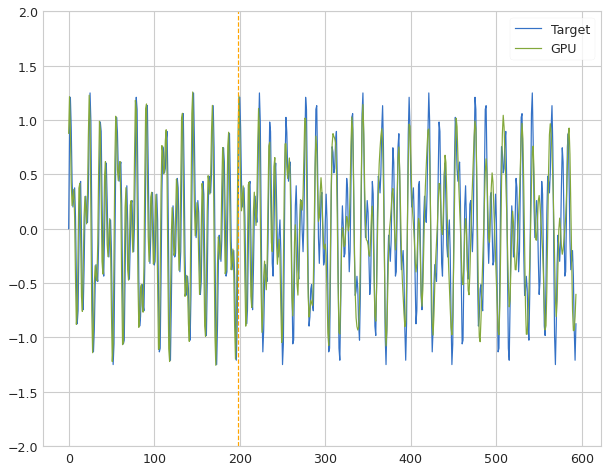

 Iter=26 a=0.430 sr=1.143 amp=0.415  ri=0.744 rr=1.502 loss=0.137181


Iter: 26 #### Diagnostic 0.137   Time 0.79  Best 0.137 NRMSE 0.137 CD 0.167
Iter: 27 #### Diagnostic 0.248   Time 0.36  Best 0.137 NRMSE 0.248 CD 0.832
Iter: 28 #### Diagnostic 0.251   Time 0.40  Best 0.137 NRMSE 0.251 CD 0.923
Iter: 29 #### Diagnostic 1000.000   Time 0.44  Best 0.137 NRMSE 2094.766 CD 0.994
Iter: 30 #### Diagnostic 0.247   Time 0.29  Best 0.137 NRMSE 0.247 CD 0.915
Iter: 31 #### Diagnostic 0.242   Time 0.36  Best 0.137 NRMSE 0.242 CD 0.825
Iter: 32 #### Diagnostic 0.402   Time 0.21  Best 0.137 NRMSE 0.402 CD 1.089
Iter: 33 #### Diagnostic 0.171   Time 0.31  Best 0.137 NRMSE 0.171 CD 0.260
Iter: 34 #### Diagnostic 0.159   Time 0.21  Best 0.137 NRMSE 0.159 CD 0.220
Iter: 35 #### Diagnostic 0.248   Time 0.24  Best 0.137 NRMSE 0.248 CD 0.899
Iter: 36 #### Diagnostic 0.250   Time 0.36  Best 0.137 NRMSE 0.250 CD 0.912
Iter: 37 #### Diagnostic 0.291   Time 0.42  Best 0.137 NRMSE 0.291 CD 0.958
Iter: 38 ##

Iter: 30 #### Diagnostic 1000.000   Time 0.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 0.246   Time 0.21  Best 1000.000 NRMSE 0.246 CD 1.002
Iter: 32 #### Diagnostic 0.245   Time 0.19  Best 1000.000 NRMSE 0.245 CD 0.890
Iter: 33 #### Diagnostic 0.224   Time 0.19  Best 1000.000 NRMSE 0.224 CD 0.587
Iter: 34 #### Diagnostic 0.241   Time 0.21  Best 1000.000 NRMSE 0.241 CD 0.826
Iter: 35 #### Diagnostic 0.246   Time 0.20  Best 1000.000 NRMSE 0.246 CD 0.998
Iter: 36 #### Diagnostic 0.251   Time 0.20  Best 1000.000 NRMSE 0.251 CD 0.921
Iter: 37 #### Diagnostic 0.254   Time 0.34  Best 1000.000 NRMSE 0.254 CD 0.774
Iter: 38 #### Diagnostic 0.187   Time 0.28  Best 1000.000 NRMSE 0.187 CD 0.350
Iter: 39 #### Diagnostic 0.164   Time 0.28  Best 1000.000 NRMSE 0.164 CD 0.227
Iter: 40 #### Diagnostic 0.277   Time 0.35  Best 1000.000 NRMSE 0.277 CD 0.926
Iter: 41 #### Diagnostic 0.194   Time 0.29  Best 1000.000 NRMSE 0.194 CD 0.345
Iter: 42 #### Diagnostic 0.298   Time 0.30  Best

Iter: 32 #### Diagnostic 0.241   Time 0.27  Best 1000.000 NRMSE 0.241 CD 0.827
Iter: 33 #### Diagnostic 0.242   Time 0.41  Best 1000.000 NRMSE 0.242 CD 0.821
Iter: 34 #### Diagnostic 0.296   Time 0.29  Best 1000.000 NRMSE 0.296 CD 0.961
Iter: 35 #### Diagnostic 0.239   Time 0.20  Best 1000.000 NRMSE 0.239 CD 0.771
Iter: 36 #### Diagnostic 0.179   Time 0.40  Best 1000.000 NRMSE 0.179 CD 0.269
Iter: 37 #### Diagnostic 0.247   Time 0.40  Best 1000.000 NRMSE 0.247 CD 0.926
Iter: 38 #### Diagnostic 0.238   Time 0.29  Best 1000.000 NRMSE 0.238 CD 0.767
Iter: 39 #### Diagnostic 0.245   Time 0.37  Best 1000.000 NRMSE 0.245 CD 0.826
Iter: 40 #### Diagnostic 0.244   Time 0.30  Best 1000.000 NRMSE 0.244 CD 0.873
Iter: 41 #### Diagnostic 0.168   Time 0.40  Best 1000.000 NRMSE 0.168 CD 0.239
Iter: 42 #### Diagnostic 0.259   Time 0.21  Best 1000.000 NRMSE 0.259 CD 0.588
Iter: 43 #### Diagnostic 0.245   Time 0.28  Best 1000.000 NRMSE 0.245 CD 0.892
Iter: 44 #### Diagnostic 0.243   Time 0.36  Best 100

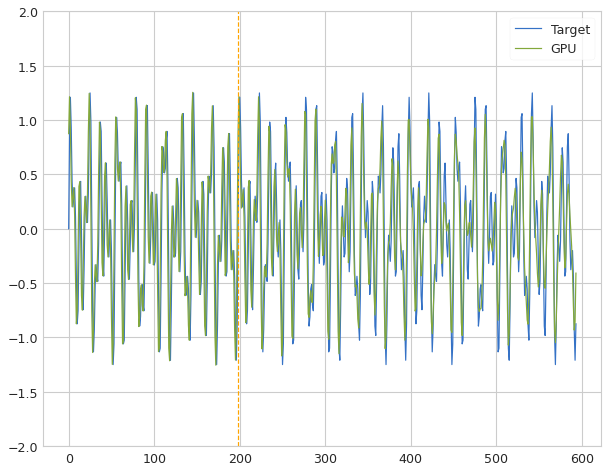

 Iter=16 a=0.326 sr=1.122 amp=0.943  ri=0.084 rr=0.976 loss=0.128433


Iter: 16 #### Diagnostic 0.128   Time 0.92  Best 0.128 NRMSE 0.128 CD 0.147
Iter: 17 #### Diagnostic 0.259   Time 0.37  Best 0.128 NRMSE 0.259 CD 1.036
Iter: 18 #### Diagnostic 0.245   Time 0.42  Best 0.128 NRMSE 0.245 CD 0.942
Iter: 19 #### Diagnostic 0.239   Time 0.40  Best 0.128 NRMSE 0.239 CD 0.783
Iter: 20 #### Diagnostic 0.245   Time 0.57  Best 0.128 NRMSE 0.245 CD 0.967
Iter: 21 #### Diagnostic 0.260   Time 0.23  Best 0.128 NRMSE 0.260 CD 0.991
Iter: 22 #### Diagnostic 0.288   Time 0.57  Best 0.128 NRMSE 0.288 CD 0.963
Iter: 23 #### Diagnostic 0.169   Time 0.41  Best 0.128 NRMSE 0.169 CD 0.240
Iter: 24 #### Diagnostic 0.243   Time 0.48  Best 0.128 NRMSE 0.243 CD 0.843
Iter: 25 #### Diagnostic 0.169   Time 0.45  Best 0.128 NRMSE 0.169 CD 0.239
Iter: 26 #### Diagnostic 0.243   Time 0.44  Best 0.128 NRMSE 0.243 CD 0.847
Iter: 27 #### Diagnostic 0.176   Time 0.51  Best 0.128 NRMSE 0.176 CD 0.303
Iter: 28 #### Dia

Iter: 20 #### Diagnostic 0.163   Time 0.24  Best 1000.000 NRMSE 0.163 CD 0.250
Iter: 21 #### Diagnostic 0.230   Time 0.32  Best 1000.000 NRMSE 0.230 CD 0.647
Iter: 22 #### Diagnostic 0.276   Time 0.25  Best 1000.000 NRMSE 0.276 CD 0.908
Iter: 23 #### Diagnostic 0.243   Time 0.21  Best 1000.000 NRMSE 0.243 CD 0.855
Iter: 24 #### Diagnostic 0.273   Time 0.23  Best 1000.000 NRMSE 0.273 CD 0.846
Iter: 25 #### Diagnostic 0.254   Time 0.24  Best 1000.000 NRMSE 0.254 CD 0.954
Iter: 26 #### Diagnostic 0.249   Time 0.35  Best 1000.000 NRMSE 0.249 CD 0.921
Iter: 27 #### Diagnostic 0.241   Time 0.57  Best 1000.000 NRMSE 0.241 CD 0.818
Iter: 28 #### Diagnostic 0.238   Time 0.44  Best 1000.000 NRMSE 0.238 CD 0.754
Iter: 29 #### Diagnostic 0.223   Time 0.41  Best 1000.000 NRMSE 0.223 CD 0.408
Iter: 30 #### Diagnostic 0.246   Time 0.28  Best 1000.000 NRMSE 0.246 CD 0.983
Iter: 31 #### Diagnostic 0.241   Time 0.21  Best 1000.000 NRMSE 0.241 CD 0.808
Iter: 32 #### Diagnostic 0.249   Time 0.19  Best 100

Iter: 15 #### Diagnostic 0.246   Time 0.43  Best 1000.000 NRMSE 0.246 CD 0.909
Iter: 16 #### Diagnostic 0.247   Time 1.30  Best 1000.000 NRMSE 0.247 CD 0.862
Iter: 17 #### Diagnostic 0.242   Time 0.62  Best 1000.000 NRMSE 0.242 CD 0.839
Iter: 18 #### Diagnostic 0.253   Time 0.47  Best 1000.000 NRMSE 0.253 CD 0.914
Iter: 19 #### Diagnostic 0.244   Time 0.34  Best 1000.000 NRMSE 0.244 CD 0.887
Iter: 20 #### Diagnostic 0.194   Time 0.38  Best 1000.000 NRMSE 0.194 CD 0.317
Iter: 21 #### Diagnostic 0.245   Time 0.26  Best 1000.000 NRMSE 0.245 CD 0.896
Iter: 22 #### Diagnostic 0.243   Time 0.21  Best 1000.000 NRMSE 0.243 CD 0.831
Iter: 23 #### Diagnostic 0.194   Time 0.20  Best 1000.000 NRMSE 0.194 CD 0.356
Iter: 24 #### Diagnostic 0.242   Time 0.25  Best 1000.000 NRMSE 0.242 CD 0.823
Iter: 25 #### Diagnostic 0.169   Time 0.39  Best 1000.000 NRMSE 0.169 CD 0.241
Iter: 26 #### Diagnostic 0.264   Time 0.33  Best 1000.000 NRMSE 0.264 CD 0.668
Iter: 27 #### Diagnostic 0.235   Time 0.61  Best 100

Iter: 17 #### Diagnostic 0.245   Time 0.30  Best 1000.000 NRMSE 0.245 CD 0.952
Iter: 18 #### Diagnostic 0.247   Time 0.40  Best 1000.000 NRMSE 0.247 CD 0.802
Iter: 19 #### Diagnostic 1000.000   Time 0.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 0.244   Time 0.38  Best 1000.000 NRMSE 0.244 CD 0.907
Iter: 21 #### Diagnostic 0.245   Time 0.51  Best 1000.000 NRMSE 0.245 CD 0.880
Iter: 22 #### Diagnostic 0.246   Time 0.53  Best 1000.000 NRMSE 0.246 CD 1.005
Iter: 23 #### Diagnostic 0.258   Time 0.34  Best 1000.000 NRMSE 0.258 CD 0.900
Iter: 24 #### Diagnostic 0.216   Time 0.37  Best 1000.000 NRMSE 0.216 CD 0.484
Iter: 25 #### Diagnostic 0.247   Time 0.95  Best 1000.000 NRMSE 0.247 CD 0.893
Iter: 26 #### Diagnostic 0.236   Time 0.62  Best 1000.000 NRMSE 0.236 CD 0.722
Iter: 27 #### Diagnostic 0.254   Time 0.38  Best 1000.000 NRMSE 0.254 CD 0.972
Iter: 28 #### Diagnostic 0.244   Time 0.78  Best 1000.000 NRMSE 0.244 CD 0.904
Iter: 29 #### Diagnostic 0.248   Time 0.34  Best

Iter: 18 #### Diagnostic 0.268   Time 0.28  Best 1000.000 NRMSE 0.268 CD 0.908
Iter: 19 #### Diagnostic 0.254   Time 0.28  Best 1000.000 NRMSE 0.254 CD 0.876
Iter: 20 #### Diagnostic 0.255   Time 0.55  Best 1000.000 NRMSE 0.255 CD 1.003
Iter: 21 #### Diagnostic 0.266   Time 1.16  Best 1000.000 NRMSE 0.266 CD 0.995
Iter: 22 #### Diagnostic 0.247   Time 0.35  Best 1000.000 NRMSE 0.247 CD 0.872
Iter: 23 #### Diagnostic 0.245   Time 1.19  Best 1000.000 NRMSE 0.245 CD 0.903
Iter: 24 #### Diagnostic 0.246   Time 0.45  Best 1000.000 NRMSE 0.246 CD 0.878
Iter: 25 #### Diagnostic 0.258   Time 0.38  Best 1000.000 NRMSE 0.258 CD 1.000
Iter: 26 #### Diagnostic 0.281   Time 0.48  Best 1000.000 NRMSE 0.281 CD 0.935
Iter: 27 #### Diagnostic 0.224   Time 0.59  Best 1000.000 NRMSE 0.224 CD 0.591
Iter: 28 #### Diagnostic 0.157   Time 0.61  Best 1000.000 NRMSE 0.157 CD 0.215
Iter: 29 #### Diagnostic 0.249   Time 0.30  Best 1000.000 NRMSE 0.249 CD 0.950
Iter: 30 #### Diagnostic 0.242   Time 0.39  Best 100

Iter: 20 #### Diagnostic 0.245   Time 0.51  Best 1000.000 NRMSE 0.245 CD 0.967
Iter: 21 #### Diagnostic 0.260   Time 0.41  Best 1000.000 NRMSE 0.260 CD 0.989
Iter: 22 #### Diagnostic 0.298   Time 0.43  Best 1000.000 NRMSE 0.298 CD 1.250
Iter: 23 #### Diagnostic 0.170   Time 0.32  Best 1000.000 NRMSE 0.170 CD 0.242
Iter: 24 #### Diagnostic 0.243   Time 0.38  Best 1000.000 NRMSE 0.243 CD 0.847
Iter: 25 #### Diagnostic 0.180   Time 0.44  Best 1000.000 NRMSE 0.180 CD 0.276
Iter: 26 #### Diagnostic 0.243   Time 0.78  Best 1000.000 NRMSE 0.243 CD 0.850
Iter: 27 #### Diagnostic 0.171   Time 0.42  Best 1000.000 NRMSE 0.171 CD 0.272
Iter: 28 #### Diagnostic 1000.000   Time 0.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 0.246   Time 0.42  Best 1000.000 NRMSE 0.246 CD 0.996
Iter: 30 #### Diagnostic 0.190   Time 0.31  Best 1000.000 NRMSE 0.190 CD 0.314
Iter: 31 #### Diagnostic 0.170   Time 0.42  Best 1000.000 NRMSE 0.170 CD 0.240
Iter: 32 #### Diagnostic 0.235   Time 0.39  Best

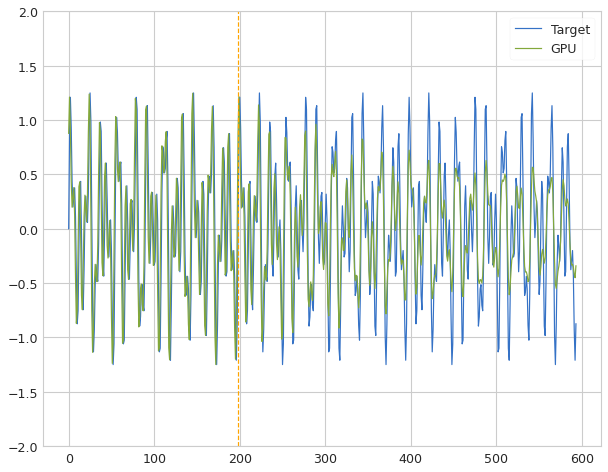

 Iter=59 a=0.331 sr=1.113 amp=0.693  ri=0.132 rr=2.479 loss=0.133972


Iter: 59 #### Diagnostic 0.134   Time 1.15  Best 0.134 NRMSE 0.134 CD 0.151
Iter: 60 #### Diagnostic 0.246   Time 0.32  Best 0.134 NRMSE 0.246 CD 0.909
Iter: 61 #### Diagnostic 0.249   Time 0.57  Best 0.134 NRMSE 0.249 CD 0.809
Iter: 62 #### Diagnostic 0.246   Time 0.63  Best 0.134 NRMSE 0.246 CD 1.011
Iter: 63 #### Diagnostic 0.248   Time 0.70  Best 0.134 NRMSE 0.248 CD 0.928
Iter: 64 #### Diagnostic 0.244   Time 0.31  Best 0.134 NRMSE 0.244 CD 0.816
Iter: 65 #### Diagnostic 0.245   Time 0.19  Best 0.134 NRMSE 0.245 CD 0.929
Iter: 66 #### Diagnostic 0.242   Time 0.23  Best 0.134 NRMSE 0.242 CD 0.802
Iter: 67 #### Diagnostic 0.246   Time 0.30  Best 0.134 NRMSE 0.246 CD 0.993
Iter: 68 #### Diagnostic 0.159   Time 0.32  Best 0.134 NRMSE 0.159 CD 0.222
Iter: 69 #### Diagnostic 0.240   Time 0.22  Best 0.134 NRMSE 0.240 CD 0.674
Iter: 70 #### Diagnostic 0.242   Time 0.27  Best 0.134 NRMSE 0.242 CD 0.839
Iter: 71 #### Dia

Iter: 62 #### Diagnostic 1.318   Time 0.43  Best 1000.000 NRMSE 1.318 CD 1.006
Iter: 63 #### Diagnostic 0.170   Time 0.52  Best 1000.000 NRMSE 0.170 CD 0.240
Iter: 64 #### Diagnostic 4.548   Time 0.36  Best 1000.000 NRMSE 4.548 CD 0.872
Iter: 65 #### Diagnostic 0.245   Time 0.41  Best 1000.000 NRMSE 0.245 CD 0.945
Iter: 66 #### Diagnostic 0.243   Time 0.44  Best 1000.000 NRMSE 0.243 CD 0.825
Iter: 67 #### Diagnostic 0.276   Time 0.37  Best 1000.000 NRMSE 0.276 CD 1.056
Iter: 68 #### Diagnostic 0.221   Time 0.45  Best 1000.000 NRMSE 0.221 CD 0.567
Iter: 69 #### Diagnostic 0.253   Time 0.37  Best 1000.000 NRMSE 0.253 CD 0.938
Iter: 70 #### Diagnostic 0.236   Time 0.40  Best 1000.000 NRMSE 0.236 CD 0.703
Iter: 71 #### Diagnostic 0.214   Time 0.38  Best 1000.000 NRMSE 0.214 CD 0.508
Iter: 72 #### Diagnostic 0.271   Time 0.31  Best 1000.000 NRMSE 0.271 CD 0.970
Iter: 73 #### Diagnostic 0.243   Time 0.37  Best 1000.000 NRMSE 0.243 CD 0.862
Iter: 74 #### Diagnostic 0.262   Time 0.90  Best 100

Iter: 56 #### Diagnostic 0.274   Time 0.35  Best 1000.000 NRMSE 0.274 CD 0.910
Iter: 57 #### Diagnostic 0.245   Time 0.39  Best 1000.000 NRMSE 0.245 CD 0.869
Iter: 58 #### Diagnostic 0.278   Time 0.44  Best 1000.000 NRMSE 0.278 CD 0.908
Iter: 59 #### Diagnostic 0.277   Time 0.28  Best 1000.000 NRMSE 0.277 CD 0.942
Iter: 60 #### Diagnostic 0.251   Time 0.26  Best 1000.000 NRMSE 0.251 CD 0.838
Iter: 61 #### Diagnostic 0.267   Time 0.25  Best 1000.000 NRMSE 0.267 CD 0.871
Iter: 62 #### Diagnostic 0.308   Time 0.43  Best 1000.000 NRMSE 0.308 CD 0.968
Iter: 63 #### Diagnostic 0.252   Time 0.27  Best 1000.000 NRMSE 0.252 CD 0.938
Iter: 64 #### Diagnostic 0.223   Time 0.26  Best 1000.000 NRMSE 0.223 CD 0.536
Iter: 65 #### Diagnostic 0.243   Time 0.24  Best 1000.000 NRMSE 0.243 CD 0.863
Iter: 66 #### Diagnostic 0.247   Time 0.25  Best 1000.000 NRMSE 0.247 CD 0.924
Iter: 67 #### Diagnostic 0.307   Time 0.25  Best 1000.000 NRMSE 0.307 CD 0.940
Iter: 68 #### Diagnostic 0.267   Time 0.21  Best 100

Iter: 58 #### Diagnostic 0.253   Time 0.38  Best 1000.000 NRMSE 0.253 CD 0.969
Iter: 59 #### Diagnostic 0.239   Time 0.35  Best 1000.000 NRMSE 0.239 CD 0.786
Iter: 60 #### Diagnostic 0.247   Time 0.36  Best 1000.000 NRMSE 0.247 CD 0.882
Iter: 61 #### Diagnostic 0.241   Time 0.57  Best 1000.000 NRMSE 0.241 CD 0.810
Iter: 62 #### Diagnostic 0.289   Time 0.45  Best 1000.000 NRMSE 0.289 CD 0.952
Iter: 63 #### Diagnostic 0.245   Time 0.68  Best 1000.000 NRMSE 0.245 CD 0.905
Iter: 64 #### Diagnostic 0.253   Time 0.60  Best 1000.000 NRMSE 0.253 CD 0.959
Iter: 65 #### Diagnostic 0.184   Time 0.35  Best 1000.000 NRMSE 0.184 CD 0.339
Iter: 66 #### Diagnostic 0.256   Time 0.29  Best 1000.000 NRMSE 0.256 CD 0.966
Iter: 67 #### Diagnostic 0.262   Time 0.27  Best 1000.000 NRMSE 0.262 CD 0.838
Iter: 68 #### Diagnostic 0.237   Time 0.21  Best 1000.000 NRMSE 0.237 CD 0.745
Iter: 69 #### Diagnostic 0.236   Time 0.34  Best 1000.000 NRMSE 0.236 CD 0.714
Iter: 70 #### Diagnostic 0.162   Time 0.20  Best 100

Iter: 60 #### Diagnostic 0.171   Time 0.43  Best 1000.000 NRMSE 0.171 CD 0.246
Iter: 61 #### Diagnostic 0.257   Time 0.43  Best 1000.000 NRMSE 0.257 CD 0.980
Iter: 62 #### Diagnostic 0.237   Time 0.27  Best 1000.000 NRMSE 0.237 CD 0.741
Iter: 63 #### Diagnostic 0.245   Time 0.33  Best 1000.000 NRMSE 0.245 CD 0.905
Iter: 64 #### Diagnostic 0.186   Time 0.32  Best 1000.000 NRMSE 0.186 CD 0.273
Iter: 65 #### Diagnostic 0.253   Time 0.35  Best 1000.000 NRMSE 0.253 CD 0.950
Iter: 66 #### Diagnostic 1.707   Time 0.42  Best 1000.000 NRMSE 1.707 CD 0.956
Iter: 67 #### Diagnostic 0.240   Time 0.66  Best 1000.000 NRMSE 0.240 CD 0.792
Iter: 68 #### Diagnostic 0.257   Time 0.54  Best 1000.000 NRMSE 0.257 CD 0.794
Iter: 69 #### Diagnostic 0.244   Time 0.81  Best 1000.000 NRMSE 0.244 CD 0.916
Iter: 70 #### Diagnostic 0.246   Time 0.83  Best 1000.000 NRMSE 0.246 CD 1.001
Iter: 71 #### Diagnostic 1000.000   Time 0.64  Best 1000.000 NRMSE 514902.205 CD 1.059
Iter: 72 #### Diagnostic 0.246   Time 0.57  

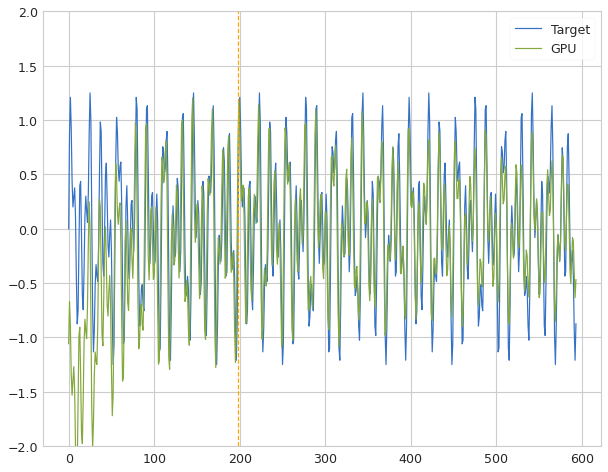

 Iter=16 a=0.326 sr=1.122 amp=0.943  ri=0.084 rr=0.976 loss=0.116736


Iter: 16 #### Diagnostic 0.117   Time 1.20  Best 0.117 NRMSE 0.117 CD 0.117
Iter: 17 #### Diagnostic 0.261   Time 0.37  Best 0.117 NRMSE 0.261 CD 1.028
Iter: 18 #### Diagnostic 0.245   Time 0.41  Best 0.117 NRMSE 0.245 CD 0.949
Iter: 19 #### Diagnostic 0.236   Time 0.47  Best 0.117 NRMSE 0.236 CD 0.731
Iter: 20 #### Diagnostic 0.245   Time 0.61  Best 0.117 NRMSE 0.245 CD 0.967
Iter: 21 #### Diagnostic 0.261   Time 0.61  Best 0.117 NRMSE 0.261 CD 0.992
Iter: 22 #### Diagnostic 0.294   Time 0.79  Best 0.117 NRMSE 0.294 CD 1.254
Iter: 23 #### Diagnostic 0.170   Time 0.59  Best 0.117 NRMSE 0.170 CD 0.240
Iter: 24 #### Diagnostic 0.243   Time 0.45  Best 0.117 NRMSE 0.243 CD 0.852
Iter: 25 #### Diagnostic 0.185   Time 0.40  Best 0.117 NRMSE 0.185 CD 0.292
Iter: 26 #### Diagnostic 0.242   Time 0.45  Best 0.117 NRMSE 0.242 CD 0.825
Iter: 27 #### Diagnostic 0.141   Time 0.47  Best 0.117 NRMSE 0.141 CD 0.175
Iter: 28 #### Dia

Iter: 19 #### Diagnostic 0.267   Time 0.38  Best 1000.000 NRMSE 0.267 CD 0.900
Iter: 20 #### Diagnostic 0.264   Time 0.42  Best 1000.000 NRMSE 0.264 CD 0.672
Iter: 21 #### Diagnostic 0.232   Time 0.35  Best 1000.000 NRMSE 0.232 CD 0.680
Iter: 22 #### Diagnostic 0.278   Time 0.33  Best 1000.000 NRMSE 0.278 CD 0.912
Iter: 23 #### Diagnostic 0.243   Time 0.41  Best 1000.000 NRMSE 0.243 CD 0.857
Iter: 24 #### Diagnostic 0.281   Time 0.41  Best 1000.000 NRMSE 0.281 CD 0.931
Iter: 25 #### Diagnostic 0.255   Time 0.37  Best 1000.000 NRMSE 0.255 CD 0.959
Iter: 26 #### Diagnostic 0.245   Time 0.40  Best 1000.000 NRMSE 0.245 CD 0.864
Iter: 27 #### Diagnostic 0.243   Time 0.40  Best 1000.000 NRMSE 0.243 CD 0.841
Iter: 28 #### Diagnostic 0.264   Time 0.43  Best 1000.000 NRMSE 0.264 CD 1.005
Iter: 29 #### Diagnostic 0.197   Time 0.33  Best 1000.000 NRMSE 0.197 CD 0.369
Iter: 30 #### Diagnostic 0.246   Time 0.23  Best 1000.000 NRMSE 0.246 CD 0.988
Iter: 31 #### Diagnostic 0.241   Time 0.50  Best 100

Iter: 13 #### Diagnostic 0.245   Time 0.49  Best 1000.000 NRMSE 0.245 CD 0.894
Iter: 14 #### Diagnostic 0.254   Time 0.78  Best 1000.000 NRMSE 0.254 CD 0.962
Iter: 15 #### Diagnostic 0.246   Time 0.48  Best 1000.000 NRMSE 0.246 CD 0.910
Iter: 16 #### Diagnostic 0.226   Time 0.31  Best 1000.000 NRMSE 0.226 CD 0.615
Iter: 17 #### Diagnostic 0.242   Time 0.33  Best 1000.000 NRMSE 0.242 CD 0.842
Iter: 18 #### Diagnostic 0.266   Time 0.37  Best 1000.000 NRMSE 0.266 CD 1.030
Iter: 19 #### Diagnostic 0.243   Time 0.78  Best 1000.000 NRMSE 0.243 CD 0.859
Iter: 20 #### Diagnostic 0.207   Time 0.65  Best 1000.000 NRMSE 0.207 CD 0.429
Iter: 21 #### Diagnostic 0.245   Time 0.34  Best 1000.000 NRMSE 0.245 CD 0.893
Iter: 22 #### Diagnostic 0.242   Time 0.35  Best 1000.000 NRMSE 0.242 CD 0.816
Iter: 23 #### Diagnostic 0.162   Time 0.36  Best 1000.000 NRMSE 0.162 CD 0.247
Iter: 24 #### Diagnostic 0.249   Time 0.32  Best 1000.000 NRMSE 0.249 CD 0.918
Iter: 25 #### Diagnostic 0.167   Time 0.29  Best 100

Iter: 15 #### Diagnostic 0.267   Time 0.55  Best 1000.000 NRMSE 0.267 CD 0.970
Iter: 16 #### Diagnostic 0.216   Time 0.63  Best 1000.000 NRMSE 0.216 CD 0.524
Iter: 17 #### Diagnostic 0.245   Time 0.51  Best 1000.000 NRMSE 0.245 CD 0.954
Iter: 18 #### Diagnostic 0.226   Time 0.22  Best 1000.000 NRMSE 0.226 CD 0.606
Iter: 19 #### Diagnostic 1000.000   Time 0.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 0.244   Time 0.46  Best 1000.000 NRMSE 0.244 CD 0.908
Iter: 21 #### Diagnostic 0.244   Time 0.46  Best 1000.000 NRMSE 0.244 CD 0.864
Iter: 22 #### Diagnostic 0.246   Time 0.40  Best 1000.000 NRMSE 0.246 CD 0.994
Iter: 23 #### Diagnostic 0.267   Time 0.36  Best 1000.000 NRMSE 0.267 CD 1.001
Iter: 24 #### Diagnostic 0.232   Time 0.26  Best 1000.000 NRMSE 0.232 CD 0.564
Iter: 25 #### Diagnostic 0.247   Time 0.20  Best 1000.000 NRMSE 0.247 CD 0.896
Iter: 26 #### Diagnostic 0.224   Time 0.51  Best 1000.000 NRMSE 0.224 CD 0.584
Iter: 27 #### Diagnostic 0.220   Time 0.33  Best

Iter: 17 #### Diagnostic 0.242   Time 0.29  Best 1000.000 NRMSE 0.242 CD 0.783
Iter: 18 #### Diagnostic 0.258   Time 0.32  Best 1000.000 NRMSE 0.258 CD 0.844
Iter: 19 #### Diagnostic 0.257   Time 0.26  Best 1000.000 NRMSE 0.257 CD 0.881
Iter: 20 #### Diagnostic 0.259   Time 0.38  Best 1000.000 NRMSE 0.259 CD 1.046
Iter: 21 #### Diagnostic 0.263   Time 0.32  Best 1000.000 NRMSE 0.263 CD 0.984
Iter: 22 #### Diagnostic 0.247   Time 0.35  Best 1000.000 NRMSE 0.247 CD 0.885
Iter: 23 #### Diagnostic 0.245   Time 0.38  Best 1000.000 NRMSE 0.245 CD 0.893
Iter: 24 #### Diagnostic 0.242   Time 0.43  Best 1000.000 NRMSE 0.242 CD 0.833
Iter: 25 #### Diagnostic 0.258   Time 0.45  Best 1000.000 NRMSE 0.258 CD 1.002
Iter: 26 #### Diagnostic 0.240   Time 0.49  Best 1000.000 NRMSE 0.240 CD 0.790
Iter: 27 #### Diagnostic 0.225   Time 0.28  Best 1000.000 NRMSE 0.225 CD 0.598
Iter: 28 #### Diagnostic 0.159   Time 0.37  Best 1000.000 NRMSE 0.159 CD 0.220
Iter: 29 #### Diagnostic 0.252   Time 0.43  Best 100

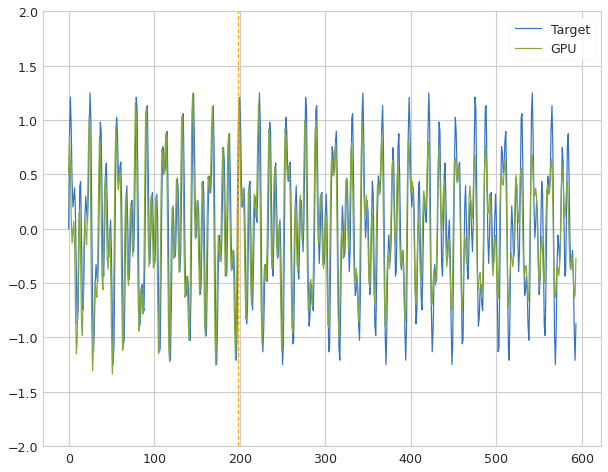

 Iter=57 a=0.419 sr=1.170 amp=0.973  ri=0.058 rr=2.700 loss=0.139280


Iter: 57 #### Diagnostic 0.139   Time 0.82  Best 0.139 NRMSE 0.139 CD 0.176
Iter: 58 #### Diagnostic 0.169   Time 0.47  Best 0.139 NRMSE 0.169 CD 0.244
Iter: 59 #### Diagnostic 0.246   Time 0.45  Best 0.139 NRMSE 0.246 CD 1.015
Iter: 60 #### Diagnostic 0.167   Time 0.50  Best 0.139 NRMSE 0.167 CD 0.235
Iter: 61 #### Diagnostic 0.265   Time 0.41  Best 0.139 NRMSE 0.265 CD 1.003
Iter: 62 #### Diagnostic 0.233   Time 0.55  Best 0.139 NRMSE 0.233 CD 0.669
Iter: 63 #### Diagnostic 0.243   Time 0.44  Best 0.139 NRMSE 0.243 CD 0.862
Iter: 64 #### Diagnostic 0.169   Time 0.40  Best 0.139 NRMSE 0.169 CD 0.239
Iter: 65 #### Diagnostic 0.251   Time 0.26  Best 0.139 NRMSE 0.251 CD 0.951
Iter: 66 #### Diagnostic 3.527   Time 0.40  Best 0.139 NRMSE 3.527 CD 1.064
Iter: 67 #### Diagnostic 0.243   Time 0.45  Best 0.139 NRMSE 0.243 CD 0.864
Iter: 68 #### Diagnostic 0.277   Time 0.41  Best 0.139 NRMSE 0.277 CD 0.915
Iter: 69 #### Dia

Iter: 59 #### Diagnostic 0.148   Time 0.32  Best 1000.000 NRMSE 0.148 CD 0.199
Iter: 60 #### Diagnostic 0.246   Time 0.32  Best 1000.000 NRMSE 0.246 CD 0.899
Iter: 61 #### Diagnostic 0.237   Time 0.39  Best 1000.000 NRMSE 0.237 CD 0.671
Iter: 62 #### Diagnostic 0.246   Time 0.44  Best 1000.000 NRMSE 0.246 CD 1.012
Iter: 63 #### Diagnostic 0.249   Time 0.44  Best 1000.000 NRMSE 0.249 CD 0.917
Iter: 64 #### Diagnostic 0.238   Time 0.70  Best 1000.000 NRMSE 0.238 CD 0.756
Iter: 65 #### Diagnostic 0.245   Time 0.47  Best 1000.000 NRMSE 0.245 CD 0.936
Iter: 66 #### Diagnostic 0.286   Time 0.50  Best 1000.000 NRMSE 0.286 CD 1.064
Iter: 67 #### Diagnostic 0.246   Time 0.32  Best 1000.000 NRMSE 0.246 CD 0.997
Iter: 68 #### Diagnostic 0.161   Time 0.30  Best 1000.000 NRMSE 0.161 CD 0.227
Iter: 69 #### Diagnostic 0.261   Time 0.37  Best 1000.000 NRMSE 0.261 CD 0.913
Iter: 70 #### Diagnostic 0.242   Time 0.32  Best 1000.000 NRMSE 0.242 CD 0.849
Iter: 71 #### Diagnostic 0.241   Time 0.38  Best 100

Iter: 61 #### Diagnostic 0.187   Time 0.33  Best 1000.000 NRMSE 0.187 CD 0.318
Iter: 62 #### Diagnostic 0.442   Time 0.37  Best 1000.000 NRMSE 0.442 CD 1.023
Iter: 63 #### Diagnostic 0.170   Time 0.37  Best 1000.000 NRMSE 0.170 CD 0.242
Iter: 64 #### Diagnostic 57.324   Time 0.24  Best 1000.000 NRMSE 57.324 CD 0.961
Iter: 65 #### Diagnostic 0.245   Time 0.31  Best 1000.000 NRMSE 0.245 CD 0.939
Iter: 66 #### Diagnostic 0.250   Time 0.32  Best 1000.000 NRMSE 0.250 CD 0.868
Iter: 67 #### Diagnostic 0.241   Time 0.45  Best 1000.000 NRMSE 0.241 CD 0.778
Iter: 68 #### Diagnostic 0.240   Time 0.65  Best 1000.000 NRMSE 0.240 CD 0.745
Iter: 69 #### Diagnostic 0.228   Time 0.23  Best 1000.000 NRMSE 0.228 CD 0.635
Iter: 70 #### Diagnostic 0.233   Time 0.46  Best 1000.000 NRMSE 0.233 CD 0.674
Iter: 71 #### Diagnostic 0.235   Time 0.32  Best 1000.000 NRMSE 0.235 CD 0.647
Iter: 72 #### Diagnostic 0.286   Time 0.42  Best 1000.000 NRMSE 0.286 CD 1.202
Iter: 73 #### Diagnostic 0.241   Time 0.45  Best 1

Iter: 55 #### Diagnostic 0.246   Time 0.32  Best 1000.000 NRMSE 0.246 CD 0.987
Iter: 56 #### Diagnostic 0.286   Time 0.33  Best 1000.000 NRMSE 0.286 CD 0.898
Iter: 57 #### Diagnostic 0.243   Time 0.49  Best 1000.000 NRMSE 0.243 CD 0.839
Iter: 58 #### Diagnostic 0.265   Time 0.45  Best 1000.000 NRMSE 0.265 CD 0.904
Iter: 59 #### Diagnostic 0.265   Time 0.43  Best 1000.000 NRMSE 0.265 CD 0.907
Iter: 60 #### Diagnostic 0.240   Time 0.30  Best 1000.000 NRMSE 0.240 CD 0.746
Iter: 61 #### Diagnostic 0.301   Time 0.47  Best 1000.000 NRMSE 0.301 CD 0.994
Iter: 62 #### Diagnostic 0.306   Time 0.39  Best 1000.000 NRMSE 0.306 CD 0.974
Iter: 63 #### Diagnostic 0.249   Time 0.38  Best 1000.000 NRMSE 0.249 CD 0.920
Iter: 64 #### Diagnostic 0.226   Time 0.39  Best 1000.000 NRMSE 0.226 CD 0.507
Iter: 65 #### Diagnostic 0.243   Time 0.49  Best 1000.000 NRMSE 0.243 CD 0.859
Iter: 66 #### Diagnostic 0.247   Time 0.51  Best 1000.000 NRMSE 0.247 CD 0.926
Iter: 67 #### Diagnostic 0.323   Time 0.26  Best 100

Iter: 57 #### Diagnostic 0.246   Time 0.41  Best 1000.000 NRMSE 0.246 CD 0.998
Iter: 58 #### Diagnostic 0.270   Time 0.41  Best 1000.000 NRMSE 0.270 CD 0.983
Iter: 59 #### Diagnostic 0.241   Time 0.73  Best 1000.000 NRMSE 0.241 CD 0.827
Iter: 60 #### Diagnostic 0.246   Time 0.54  Best 1000.000 NRMSE 0.246 CD 0.868
Iter: 61 #### Diagnostic 0.240   Time 0.32  Best 1000.000 NRMSE 0.240 CD 0.800
Iter: 62 #### Diagnostic 0.281   Time 0.86  Best 1000.000 NRMSE 0.281 CD 0.945
Iter: 63 #### Diagnostic 0.245   Time 0.36  Best 1000.000 NRMSE 0.245 CD 0.905
Iter: 64 #### Diagnostic 0.254   Time 0.44  Best 1000.000 NRMSE 0.254 CD 0.971
Iter: 65 #### Diagnostic 0.157   Time 0.38  Best 1000.000 NRMSE 0.157 CD 0.230
Iter: 66 #### Diagnostic 0.257   Time 0.37  Best 1000.000 NRMSE 0.257 CD 0.969
Iter: 67 #### Diagnostic 1000.000   Time 0.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 0.236   Time 0.22  Best 1000.000 NRMSE 0.236 CD 0.735
Iter: 69 #### Diagnostic 0.239   Time 0.23  Best

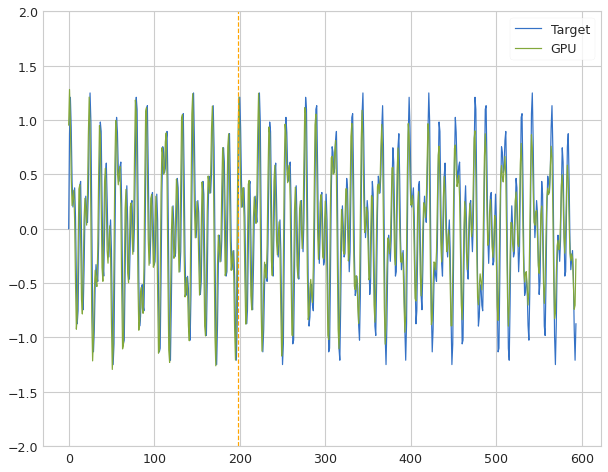

 Iter=57 a=0.419 sr=1.170 amp=0.973  ri=0.058 rr=2.700 loss=0.133299


Iter: 57 #### Diagnostic 0.133   Time 0.92  Best 0.133 NRMSE 0.133 CD 0.161
Iter: 58 #### Diagnostic 0.167   Time 0.57  Best 0.133 NRMSE 0.167 CD 0.237
Iter: 59 #### Diagnostic 0.246   Time 0.36  Best 0.133 NRMSE 0.246 CD 1.014
Iter: 60 #### Diagnostic 0.168   Time 0.37  Best 0.133 NRMSE 0.168 CD 0.237
Iter: 61 #### Diagnostic 0.260   Time 0.54  Best 0.133 NRMSE 0.260 CD 0.991
Iter: 62 #### Diagnostic 0.238   Time 0.64  Best 0.133 NRMSE 0.238 CD 0.768
Iter: 63 #### Diagnostic 0.244   Time 0.45  Best 0.133 NRMSE 0.244 CD 0.887
Iter: 64 #### Diagnostic 0.250   Time 0.45  Best 0.133 NRMSE 0.250 CD 0.520
Iter: 65 #### Diagnostic 0.246   Time 0.43  Best 0.133 NRMSE 0.246 CD 0.885
Iter: 66 #### Diagnostic 1.696   Time 0.36  Best 0.133 NRMSE 1.696 CD 0.926
Iter: 67 #### Diagnostic 0.241   Time 0.22  Best 0.133 NRMSE 0.241 CD 0.812
Iter: 68 #### Diagnostic 0.261   Time 0.22  Best 0.133 NRMSE 0.261 CD 0.877
Iter: 69 #### Dia

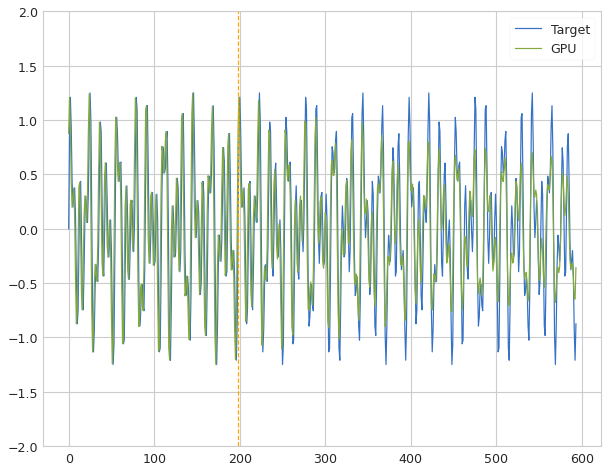

 Iter=59 a=0.331 sr=1.113 amp=0.693  ri=0.132 rr=2.479 loss=0.128470


Iter: 59 #### Diagnostic 0.128   Time 1.45  Best 0.128 NRMSE 0.128 CD 0.146
Iter: 60 #### Diagnostic 0.246   Time 0.35  Best 0.128 NRMSE 0.246 CD 0.909
Iter: 61 #### Diagnostic 0.245   Time 0.20  Best 0.128 NRMSE 0.245 CD 0.833
Iter: 62 #### Diagnostic 0.246   Time 0.19  Best 0.128 NRMSE 0.246 CD 1.005
Iter: 63 #### Diagnostic 0.245   Time 0.21  Best 0.128 NRMSE 0.245 CD 0.908
Iter: 64 #### Diagnostic 0.255   Time 0.21  Best 0.128 NRMSE 0.255 CD 0.969
Iter: 65 #### Diagnostic 0.245   Time 0.36  Best 0.128 NRMSE 0.245 CD 0.931
Iter: 66 #### Diagnostic 0.264   Time 0.45  Best 0.128 NRMSE 0.264 CD 0.963
Iter: 67 #### Diagnostic 0.246   Time 0.41  Best 0.128 NRMSE 0.246 CD 0.995
Iter: 68 #### Diagnostic 0.160   Time 0.82  Best 0.128 NRMSE 0.160 CD 0.225
Iter: 69 #### Diagnostic 0.264   Time 0.54  Best 0.128 NRMSE 0.264 CD 0.872
Iter: 70 #### Diagnostic 0.243   Time 0.27  Best 0.128 NRMSE 0.243 CD 0.856
Iter: 71 #### Dia

Iter: 61 #### Diagnostic 0.155   Time 0.53  Best 1000.000 NRMSE 0.155 CD 0.210
Iter: 62 #### Diagnostic 1.012   Time 0.74  Best 1000.000 NRMSE 1.012 CD 1.009
Iter: 63 #### Diagnostic 0.170   Time 0.36  Best 1000.000 NRMSE 0.170 CD 0.242
Iter: 64 #### Diagnostic 194.204   Time 0.56  Best 1000.000 NRMSE 194.204 CD 0.976
Iter: 65 #### Diagnostic 0.245   Time 0.44  Best 1000.000 NRMSE 0.245 CD 0.946
Iter: 66 #### Diagnostic 0.243   Time 0.41  Best 1000.000 NRMSE 0.243 CD 0.834
Iter: 67 #### Diagnostic 0.259   Time 0.47  Best 1000.000 NRMSE 0.259 CD 0.927
Iter: 68 #### Diagnostic 0.219   Time 0.21  Best 1000.000 NRMSE 0.219 CD 0.553
Iter: 69 #### Diagnostic 0.255   Time 0.21  Best 1000.000 NRMSE 0.255 CD 0.923
Iter: 70 #### Diagnostic 0.232   Time 0.59  Best 1000.000 NRMSE 0.232 CD 0.676
Iter: 71 #### Diagnostic 0.239   Time 0.45  Best 1000.000 NRMSE 0.239 CD 0.665
Iter: 72 #### Diagnostic 0.299   Time 0.40  Best 1000.000 NRMSE 0.299 CD 1.091
Iter: 73 #### Diagnostic 0.244   Time 0.41  Best

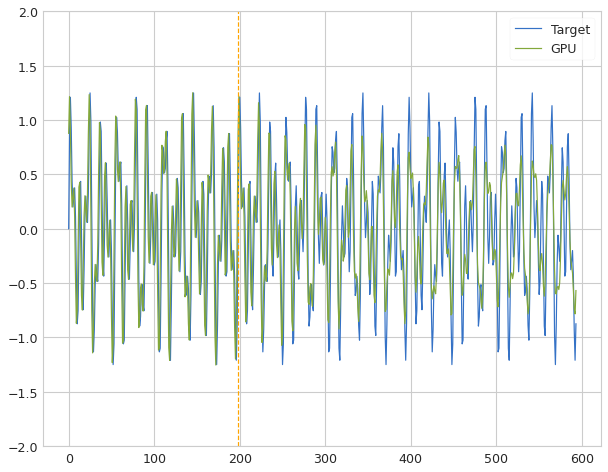

 Iter=23 a=0.305 sr=0.837 amp=0.781  ri=0.460 rr=3.231 loss=0.135257


Iter: 23 #### Diagnostic 0.135   Time 0.99  Best 0.135 NRMSE 0.135 CD 0.165
Iter: 24 #### Diagnostic 0.241   Time 0.52  Best 0.135 NRMSE 0.241 CD 0.796
Iter: 25 #### Diagnostic 0.164   Time 0.52  Best 0.135 NRMSE 0.164 CD 0.235
Iter: 26 #### Diagnostic 0.246   Time 0.75  Best 0.135 NRMSE 0.246 CD 0.794
Iter: 27 #### Diagnostic 0.263   Time 0.47  Best 0.135 NRMSE 0.263 CD 0.998
Iter: 28 #### Diagnostic 0.252   Time 0.21  Best 0.135 NRMSE 0.252 CD 0.933
Iter: 29 #### Diagnostic 25.398   Time 0.19  Best 0.135 NRMSE 25.398 CD 0.980
Iter: 30 #### Diagnostic 0.246   Time 0.18  Best 0.135 NRMSE 0.246 CD 0.911
Iter: 31 #### Diagnostic 0.239   Time 0.22  Best 0.135 NRMSE 0.239 CD 0.781
Iter: 32 #### Diagnostic 0.358   Time 0.55  Best 0.135 NRMSE 0.358 CD 0.901
Iter: 33 #### Diagnostic 0.292   Time 0.40  Best 0.135 NRMSE 0.292 CD 0.826
Iter: 34 #### Diagnostic 0.323   Time 0.20  Best 0.135 NRMSE 0.323 CD 0.948
Iter: 35 #### D

Iter: 27 #### Diagnostic 0.246   Time 0.36  Best 1000.000 NRMSE 0.246 CD 0.901
Iter: 28 #### Diagnostic 0.245   Time 0.50  Best 1000.000 NRMSE 0.245 CD 0.960
Iter: 29 #### Diagnostic 0.247   Time 0.19  Best 1000.000 NRMSE 0.247 CD 0.892
Iter: 30 #### Diagnostic 0.178   Time 0.48  Best 1000.000 NRMSE 0.178 CD 0.307
Iter: 31 #### Diagnostic 0.246   Time 0.26  Best 1000.000 NRMSE 0.246 CD 0.993
Iter: 32 #### Diagnostic 0.245   Time 0.19  Best 1000.000 NRMSE 0.245 CD 0.887
Iter: 33 #### Diagnostic 0.213   Time 0.29  Best 1000.000 NRMSE 0.213 CD 0.504
Iter: 34 #### Diagnostic 0.242   Time 0.46  Best 1000.000 NRMSE 0.242 CD 0.837
Iter: 35 #### Diagnostic 0.246   Time 0.27  Best 1000.000 NRMSE 0.246 CD 0.993
Iter: 36 #### Diagnostic 0.313   Time 0.37  Best 1000.000 NRMSE 0.313 CD 0.976
Iter: 37 #### Diagnostic 0.283   Time 0.37  Best 1000.000 NRMSE 0.283 CD 1.000
Iter: 38 #### Diagnostic 0.203   Time 0.41  Best 1000.000 NRMSE 0.203 CD 0.421
Iter: 39 #### Diagnostic 0.162   Time 0.31  Best 100

Iter: 29 #### Diagnostic 0.241   Time 0.22  Best 1000.000 NRMSE 0.241 CD 0.807
Iter: 30 #### Diagnostic 0.243   Time 0.39  Best 1000.000 NRMSE 0.243 CD 0.848
Iter: 31 #### Diagnostic 0.158   Time 0.29  Best 1000.000 NRMSE 0.158 CD 0.218
Iter: 32 #### Diagnostic 0.240   Time 0.41  Best 1000.000 NRMSE 0.240 CD 0.805
Iter: 33 #### Diagnostic 0.243   Time 0.54  Best 1000.000 NRMSE 0.243 CD 0.858
Iter: 34 #### Diagnostic 0.292   Time 0.51  Best 1000.000 NRMSE 0.292 CD 0.963
Iter: 35 #### Diagnostic 0.240   Time 0.64  Best 1000.000 NRMSE 0.240 CD 0.793
Iter: 36 #### Diagnostic 0.169   Time 0.75  Best 1000.000 NRMSE 0.169 CD 0.240
Iter: 37 #### Diagnostic 0.247   Time 0.87  Best 1000.000 NRMSE 0.247 CD 0.923
Iter: 38 #### Diagnostic 0.247   Time 0.44  Best 1000.000 NRMSE 0.247 CD 0.892
Iter: 39 #### Diagnostic 0.249   Time 0.40  Best 1000.000 NRMSE 0.249 CD 0.812
Iter: 40 #### Diagnostic 0.242   Time 0.32  Best 1000.000 NRMSE 0.242 CD 0.833
Iter: 41 #### Diagnostic 0.158   Time 0.43  Best 100

Iter: 31 #### Diagnostic 0.283   Time 0.46  Best 1000.000 NRMSE 0.283 CD 0.841
Iter: 32 #### Diagnostic 0.236   Time 0.42  Best 1000.000 NRMSE 0.236 CD 0.720
Iter: 33 #### Diagnostic 0.249   Time 0.41  Best 1000.000 NRMSE 0.249 CD 0.901
Iter: 34 #### Diagnostic 0.260   Time 0.32  Best 1000.000 NRMSE 0.260 CD 0.973
Iter: 35 #### Diagnostic 0.290   Time 0.53  Best 1000.000 NRMSE 0.290 CD 1.116
Iter: 36 #### Diagnostic 6.226   Time 1.00  Best 1000.000 NRMSE 6.226 CD 1.042
Iter: 37 #### Diagnostic 0.245   Time 0.67  Best 1000.000 NRMSE 0.245 CD 0.968
Iter: 38 #### Diagnostic 0.246   Time 0.30  Best 1000.000 NRMSE 0.246 CD 0.908
Iter: 39 #### Diagnostic 0.244   Time 0.28  Best 1000.000 NRMSE 0.244 CD 0.909
Iter: 40 #### Diagnostic 0.243   Time 0.18  Best 1000.000 NRMSE 0.243 CD 0.871
Iter: 41 #### Diagnostic 0.334   Time 0.21  Best 1000.000 NRMSE 0.334 CD 0.998
Iter: 42 #### Diagnostic 0.280   Time 0.41  Best 1000.000 NRMSE 0.280 CD 0.970
Iter: 43 #### Diagnostic 0.207   Time 0.42  Best 100

Iter: 33 #### Diagnostic 0.244   Time 0.19  Best 1000.000 NRMSE 0.244 CD 0.910
Iter: 34 #### Diagnostic 0.244   Time 0.22  Best 1000.000 NRMSE 0.244 CD 0.892
Iter: 35 #### Diagnostic 0.201   Time 0.33  Best 1000.000 NRMSE 0.201 CD 0.353
Iter: 36 #### Diagnostic 0.242   Time 0.39  Best 1000.000 NRMSE 0.242 CD 0.845
Iter: 37 #### Diagnostic 0.299   Time 0.32  Best 1000.000 NRMSE 0.299 CD 0.867
Iter: 38 #### Diagnostic 0.228   Time 0.70  Best 1000.000 NRMSE 0.228 CD 0.612
Iter: 39 #### Diagnostic 0.254   Time 0.30  Best 1000.000 NRMSE 0.254 CD 0.966
Iter: 40 #### Diagnostic 0.240   Time 0.33  Best 1000.000 NRMSE 0.240 CD 0.803
Iter: 41 #### Diagnostic 0.258   Time 0.36  Best 1000.000 NRMSE 0.258 CD 0.920
Iter: 42 #### Diagnostic 0.307   Time 0.42  Best 1000.000 NRMSE 0.307 CD 1.030
Iter: 43 #### Diagnostic 1000.000   Time 0.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 0.243   Time 0.36  Best 1000.000 NRMSE 0.243 CD 0.860
Iter: 45 #### Diagnostic 0.265   Time 0.41  Best

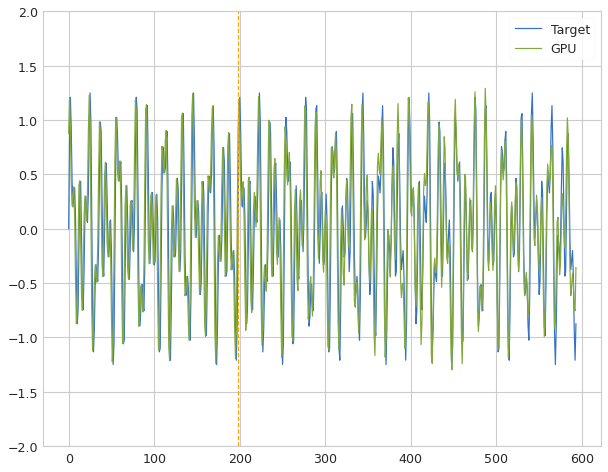

 Iter=20 a=0.256 sr=0.870 amp=0.913  ri=0.877 rr=4.039 loss=0.126910


Iter: 20 #### Diagnostic 0.127   Time 1.17  Best 0.127 NRMSE 0.127 CD 0.135
Iter: 21 #### Diagnostic 0.245   Time 0.48  Best 0.127 NRMSE 0.245 CD 0.892
Iter: 22 #### Diagnostic 0.288   Time 0.44  Best 0.127 NRMSE 0.288 CD 1.013
Iter: 23 #### Diagnostic 0.165   Time 0.41  Best 0.127 NRMSE 0.165 CD 0.253
Iter: 24 #### Diagnostic 0.249   Time 0.48  Best 0.127 NRMSE 0.249 CD 0.899
Iter: 25 #### Diagnostic 0.157   Time 0.31  Best 0.127 NRMSE 0.157 CD 0.204
Iter: 26 #### Diagnostic 0.150   Time 0.38  Best 0.127 NRMSE 0.150 CD 0.206
Iter: 27 #### Diagnostic 0.226   Time 0.41  Best 0.127 NRMSE 0.226 CD 0.608
Iter: 28 #### Diagnostic 0.252   Time 0.45  Best 0.127 NRMSE 0.252 CD 0.935
Iter: 29 #### Diagnostic 176.294   Time 0.38  Best 0.127 NRMSE 176.294 CD 0.988
Iter: 30 #### Diagnostic 0.246   Time 0.46  Best 0.127 NRMSE 0.246 CD 0.908
Iter: 31 #### Diagnostic 0.241   Time 0.48  Best 0.127 NRMSE 0.241 CD 0.799
Iter: 32 ####

Iter: 24 #### Diagnostic 0.241   Time 0.59  Best 1000.000 NRMSE 0.241 CD 0.647
Iter: 25 #### Diagnostic 0.247   Time 0.51  Best 1000.000 NRMSE 0.247 CD 0.900
Iter: 26 #### Diagnostic 0.232   Time 0.77  Best 1000.000 NRMSE 0.232 CD 0.677
Iter: 27 #### Diagnostic 0.233   Time 0.75  Best 1000.000 NRMSE 0.233 CD 0.675
Iter: 28 #### Diagnostic 0.245   Time 0.50  Best 1000.000 NRMSE 0.245 CD 0.937
Iter: 29 #### Diagnostic 0.248   Time 0.31  Best 1000.000 NRMSE 0.248 CD 0.896
Iter: 30 #### Diagnostic 1000.000   Time 0.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 0.246   Time 0.30  Best 1000.000 NRMSE 0.246 CD 0.990
Iter: 32 #### Diagnostic 0.245   Time 0.33  Best 1000.000 NRMSE 0.245 CD 0.887
Iter: 33 #### Diagnostic 0.226   Time 0.35  Best 1000.000 NRMSE 0.226 CD 0.611
Iter: 34 #### Diagnostic 0.243   Time 0.73  Best 1000.000 NRMSE 0.243 CD 0.878
Iter: 35 #### Diagnostic 0.246   Time 0.48  Best 1000.000 NRMSE 0.246 CD 0.992
Iter: 36 #### Diagnostic 0.294   Time 0.49  Best

Iter: 27 #### Diagnostic 0.233   Time 0.24  Best 1000.000 NRMSE 0.233 CD 0.687
Iter: 28 #### Diagnostic 0.147   Time 0.58  Best 1000.000 NRMSE 0.147 CD 0.194
Iter: 29 #### Diagnostic 0.245   Time 0.33  Best 1000.000 NRMSE 0.245 CD 0.892
Iter: 30 #### Diagnostic 0.245   Time 0.20  Best 1000.000 NRMSE 0.245 CD 0.877
Iter: 31 #### Diagnostic 0.154   Time 0.25  Best 1000.000 NRMSE 0.154 CD 0.211
Iter: 32 #### Diagnostic 0.242   Time 0.85  Best 1000.000 NRMSE 0.242 CD 0.833
Iter: 33 #### Diagnostic 0.243   Time 0.35  Best 1000.000 NRMSE 0.243 CD 0.851
Iter: 34 #### Diagnostic 0.313   Time 0.36  Best 1000.000 NRMSE 0.313 CD 0.977
Iter: 35 #### Diagnostic 0.245   Time 0.89  Best 1000.000 NRMSE 0.245 CD 0.867
Iter: 36 #### Diagnostic 0.177   Time 0.49  Best 1000.000 NRMSE 0.177 CD 0.268
Iter: 37 #### Diagnostic 0.247   Time 0.30  Best 1000.000 NRMSE 0.247 CD 0.924
Iter: 38 #### Diagnostic 0.246   Time 0.31  Best 1000.000 NRMSE 0.246 CD 0.882
Iter: 39 #### Diagnostic 0.264   Time 0.48  Best 100

Iter: 28 #### Diagnostic 0.277   Time 0.64  Best 1000.000 NRMSE 0.277 CD 0.929
Iter: 29 #### Diagnostic 0.246   Time 0.51  Best 1000.000 NRMSE 0.246 CD 0.996
Iter: 30 #### Diagnostic 0.165   Time 0.58  Best 1000.000 NRMSE 0.165 CD 0.224
Iter: 31 #### Diagnostic 0.168   Time 0.42  Best 1000.000 NRMSE 0.168 CD 0.240
Iter: 32 #### Diagnostic 0.240   Time 0.30  Best 1000.000 NRMSE 0.240 CD 0.787
Iter: 33 #### Diagnostic 0.262   Time 0.29  Best 1000.000 NRMSE 0.262 CD 0.930
Iter: 34 #### Diagnostic 0.252   Time 0.26  Best 1000.000 NRMSE 0.252 CD 0.920
Iter: 35 #### Diagnostic 0.262   Time 0.28  Best 1000.000 NRMSE 0.262 CD 0.868
Iter: 36 #### Diagnostic 1.689   Time 0.44  Best 1000.000 NRMSE 1.689 CD 0.990
Iter: 37 #### Diagnostic 0.245   Time 0.52  Best 1000.000 NRMSE 0.245 CD 0.951
Iter: 38 #### Diagnostic 0.246   Time 0.36  Best 1000.000 NRMSE 0.246 CD 0.908
Iter: 39 #### Diagnostic 0.244   Time 0.19  Best 1000.000 NRMSE 0.244 CD 0.913
Iter: 40 #### Diagnostic 0.243   Time 0.21  Best 100

Iter: 30 #### Diagnostic 0.245   Time 0.53  Best 1000.000 NRMSE 0.245 CD 0.966
Iter: 31 #### Diagnostic 0.248   Time 0.38  Best 1000.000 NRMSE 0.248 CD 0.918
Iter: 32 #### Diagnostic 0.250   Time 0.28  Best 1000.000 NRMSE 0.250 CD 0.942
Iter: 33 #### Diagnostic 0.244   Time 0.31  Best 1000.000 NRMSE 0.244 CD 0.918
Iter: 34 #### Diagnostic 0.244   Time 0.29  Best 1000.000 NRMSE 0.244 CD 0.895
Iter: 35 #### Diagnostic 0.175   Time 0.45  Best 1000.000 NRMSE 0.175 CD 0.256
Iter: 36 #### Diagnostic 0.243   Time 0.45  Best 1000.000 NRMSE 0.243 CD 0.862
Iter: 37 #### Diagnostic 0.264   Time 0.34  Best 1000.000 NRMSE 0.264 CD 0.624
Iter: 38 #### Diagnostic 0.203   Time 0.20  Best 1000.000 NRMSE 0.203 CD 0.434
Iter: 39 #### Diagnostic 0.265   Time 0.19  Best 1000.000 NRMSE 0.265 CD 0.964
Iter: 40 #### Diagnostic 0.244   Time 0.19  Best 1000.000 NRMSE 0.244 CD 0.874
Iter: 41 #### Diagnostic 0.262   Time 0.26  Best 1000.000 NRMSE 0.262 CD 0.996
Iter: 42 #### Diagnostic 0.302   Time 0.31  Best 100

Iter: 25 #### Diagnostic 0.169   Time 0.49  Best 1000.000 NRMSE 0.169 CD 0.259
Iter: 26 #### Diagnostic 0.274   Time 0.41  Best 1000.000 NRMSE 0.274 CD 0.666
Iter: 27 #### Diagnostic 0.261   Time 0.63  Best 1000.000 NRMSE 0.261 CD 0.979
Iter: 28 #### Diagnostic 0.252   Time 0.44  Best 1000.000 NRMSE 0.252 CD 0.937
Iter: 29 #### Diagnostic 921.098   Time 0.72  Best 1000.000 NRMSE 921.098 CD 1.007
Iter: 30 #### Diagnostic 0.246   Time 0.32  Best 1000.000 NRMSE 0.246 CD 0.906
Iter: 31 #### Diagnostic 0.239   Time 0.48  Best 1000.000 NRMSE 0.239 CD 0.773
Iter: 32 #### Diagnostic 0.474   Time 0.54  Best 1000.000 NRMSE 0.474 CD 1.091
Iter: 33 #### Diagnostic 0.270   Time 0.35  Best 1000.000 NRMSE 0.270 CD 0.773
Iter: 34 #### Diagnostic 0.173   Time 0.64  Best 1000.000 NRMSE 0.173 CD 0.270
Iter: 35 #### Diagnostic 0.232   Time 0.23  Best 1000.000 NRMSE 0.232 CD 0.665
Iter: 36 #### Diagnostic 0.309   Time 0.31  Best 1000.000 NRMSE 0.309 CD 0.972
Iter: 37 #### Diagnostic 0.241   Time 0.25  Best

Iter: 26 #### Diagnostic 0.240   Time 0.63  Best 1000.000 NRMSE 0.240 CD 0.786
Iter: 27 #### Diagnostic 0.237   Time 0.59  Best 1000.000 NRMSE 0.237 CD 0.745
Iter: 28 #### Diagnostic 0.245   Time 0.54  Best 1000.000 NRMSE 0.245 CD 0.958
Iter: 29 #### Diagnostic 0.245   Time 0.70  Best 1000.000 NRMSE 0.245 CD 0.883
Iter: 30 #### Diagnostic 0.160   Time 0.64  Best 1000.000 NRMSE 0.160 CD 0.242
Iter: 31 #### Diagnostic 0.246   Time 0.85  Best 1000.000 NRMSE 0.246 CD 0.983
Iter: 32 #### Diagnostic 0.245   Time 0.44  Best 1000.000 NRMSE 0.245 CD 0.887
Iter: 33 #### Diagnostic 0.232   Time 0.31  Best 1000.000 NRMSE 0.232 CD 0.674
Iter: 34 #### Diagnostic 0.243   Time 0.35  Best 1000.000 NRMSE 0.243 CD 0.853
Iter: 35 #### Diagnostic 0.246   Time 0.41  Best 1000.000 NRMSE 0.246 CD 0.998
Iter: 36 #### Diagnostic 0.318   Time 0.31  Best 1000.000 NRMSE 0.318 CD 0.967
Iter: 37 #### Diagnostic 0.276   Time 0.78  Best 1000.000 NRMSE 0.276 CD 0.872
Iter: 38 #### Diagnostic 0.257   Time 0.63  Best 100

Iter: 28 #### Diagnostic 0.153   Time 0.42  Best 1000.000 NRMSE 0.153 CD 0.210
Iter: 29 #### Diagnostic 0.245   Time 0.79  Best 1000.000 NRMSE 0.245 CD 0.913
Iter: 30 #### Diagnostic 0.244   Time 0.50  Best 1000.000 NRMSE 0.244 CD 0.863
Iter: 31 #### Diagnostic 0.150   Time 0.39  Best 1000.000 NRMSE 0.150 CD 0.205
Iter: 32 #### Diagnostic 0.242   Time 0.45  Best 1000.000 NRMSE 0.242 CD 0.831
Iter: 33 #### Diagnostic 0.242   Time 0.34  Best 1000.000 NRMSE 0.242 CD 0.831
Iter: 34 #### Diagnostic 0.285   Time 0.32  Best 1000.000 NRMSE 0.285 CD 0.941
Iter: 35 #### Diagnostic 0.239   Time 0.31  Best 1000.000 NRMSE 0.239 CD 0.778
Iter: 36 #### Diagnostic 0.182   Time 0.61  Best 1000.000 NRMSE 0.182 CD 0.289
Iter: 37 #### Diagnostic 0.247   Time 0.66  Best 1000.000 NRMSE 0.247 CD 0.924
Iter: 38 #### Diagnostic 0.246   Time 0.51  Best 1000.000 NRMSE 0.246 CD 0.881
Iter: 39 #### Diagnostic 0.260   Time 0.30  Best 1000.000 NRMSE 0.260 CD 0.888
Iter: 40 #### Diagnostic 0.242   Time 0.31  Best 100

Iter: 30 #### Diagnostic 1000.000   Time 0.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 0.165   Time 1.03  Best 1000.000 NRMSE 0.165 CD 0.235
Iter: 32 #### Diagnostic 0.243   Time 0.65  Best 1000.000 NRMSE 0.243 CD 0.854
Iter: 33 #### Diagnostic 0.255   Time 0.32  Best 1000.000 NRMSE 0.255 CD 0.906
Iter: 34 #### Diagnostic 0.259   Time 0.19  Best 1000.000 NRMSE 0.259 CD 0.974
Iter: 35 #### Diagnostic 0.275   Time 0.56  Best 1000.000 NRMSE 0.275 CD 1.009
Iter: 36 #### Diagnostic 1000.000   Time 0.34  Best 1000.000 NRMSE 13560.208 CD 1.012
Iter: 37 #### Diagnostic 0.245   Time 0.21  Best 1000.000 NRMSE 0.245 CD 0.952
Iter: 38 #### Diagnostic 0.246   Time 0.19  Best 1000.000 NRMSE 0.246 CD 0.907
Iter: 39 #### Diagnostic 0.244   Time 0.20  Best 1000.000 NRMSE 0.244 CD 0.901
Iter: 40 #### Diagnostic 0.243   Time 0.40  Best 1000.000 NRMSE 0.243 CD 0.871
Iter: 41 #### Diagnostic 0.328   Time 0.33  Best 1000.000 NRMSE 0.328 CD 0.987
Iter: 42 #### Diagnostic 0.271   Time 0.3

Iter: 32 #### Diagnostic 0.250   Time 0.39  Best 1000.000 NRMSE 0.250 CD 0.941
Iter: 33 #### Diagnostic 0.245   Time 0.32  Best 1000.000 NRMSE 0.245 CD 0.951
Iter: 34 #### Diagnostic 0.244   Time 0.24  Best 1000.000 NRMSE 0.244 CD 0.905
Iter: 35 #### Diagnostic 0.173   Time 0.45  Best 1000.000 NRMSE 0.173 CD 0.261
Iter: 36 #### Diagnostic 0.242   Time 0.54  Best 1000.000 NRMSE 0.242 CD 0.851
Iter: 37 #### Diagnostic 0.185   Time 0.88  Best 1000.000 NRMSE 0.185 CD 0.289
Iter: 38 #### Diagnostic 0.225   Time 0.47  Best 1000.000 NRMSE 0.225 CD 0.579
Iter: 39 #### Diagnostic 0.254   Time 0.40  Best 1000.000 NRMSE 0.254 CD 0.961
Iter: 40 #### Diagnostic 0.241   Time 0.41  Best 1000.000 NRMSE 0.241 CD 0.824
Iter: 41 #### Diagnostic 0.249   Time 0.34  Best 1000.000 NRMSE 0.249 CD 0.872
Iter: 42 #### Diagnostic 0.274   Time 0.55  Best 1000.000 NRMSE 0.274 CD 0.978
Iter: 43 #### Diagnostic 0.208   Time 0.56  Best 1000.000 NRMSE 0.208 CD 0.342
Iter: 44 #### Diagnostic 0.243   Time 0.20  Best 100

Iter: 30 #### Diagnostic 0.246   Time 0.67  Best 1000.000 NRMSE 0.246 CD 0.909
Iter: 31 #### Diagnostic 0.241   Time 0.43  Best 1000.000 NRMSE 0.241 CD 0.810
Iter: 32 #### Diagnostic 0.278   Time 0.53  Best 1000.000 NRMSE 0.278 CD 0.898
Iter: 33 #### Diagnostic 0.273   Time 0.38  Best 1000.000 NRMSE 0.273 CD 0.805
Iter: 34 #### Diagnostic 0.185   Time 0.36  Best 1000.000 NRMSE 0.185 CD 0.334
Iter: 35 #### Diagnostic 0.237   Time 0.28  Best 1000.000 NRMSE 0.237 CD 0.742
Iter: 36 #### Diagnostic 0.257   Time 0.28  Best 1000.000 NRMSE 0.257 CD 0.929
Iter: 37 #### Diagnostic 0.285   Time 0.23  Best 1000.000 NRMSE 0.285 CD 0.912
Iter: 38 #### Diagnostic 0.248   Time 0.35  Best 1000.000 NRMSE 0.248 CD 0.905
Iter: 39 #### Diagnostic 0.212   Time 0.35  Best 1000.000 NRMSE 0.212 CD 0.492
Iter: 40 #### Diagnostic 0.246   Time 0.24  Best 1000.000 NRMSE 0.246 CD 1.012
Iter: 41 #### Diagnostic 0.241   Time 0.19  Best 1000.000 NRMSE 0.241 CD 0.813
Iter: 42 #### Diagnostic 0.245   Time 0.58  Best 100

Iter: 32 #### Diagnostic 0.245   Time 0.36  Best 1000.000 NRMSE 0.245 CD 0.887
Iter: 33 #### Diagnostic 0.217   Time 0.33  Best 1000.000 NRMSE 0.217 CD 0.529
Iter: 34 #### Diagnostic 0.242   Time 0.57  Best 1000.000 NRMSE 0.242 CD 0.828
Iter: 35 #### Diagnostic 0.246   Time 0.47  Best 1000.000 NRMSE 0.246 CD 0.995
Iter: 36 #### Diagnostic 0.284   Time 0.41  Best 1000.000 NRMSE 0.284 CD 0.959
Iter: 37 #### Diagnostic 0.297   Time 0.47  Best 1000.000 NRMSE 0.297 CD 0.912
Iter: 38 #### Diagnostic 0.269   Time 0.40  Best 1000.000 NRMSE 0.269 CD 0.798
Iter: 39 #### Diagnostic 0.165   Time 0.36  Best 1000.000 NRMSE 0.165 CD 0.229
Iter: 40 #### Diagnostic 0.350   Time 0.62  Best 1000.000 NRMSE 0.350 CD 0.967
Iter: 41 #### Diagnostic 0.200   Time 0.75  Best 1000.000 NRMSE 0.200 CD 0.402
Iter: 42 #### Diagnostic 0.251   Time 0.65  Best 1000.000 NRMSE 0.251 CD 0.947
Iter: 43 #### Diagnostic 0.263   Time 0.75  Best 1000.000 NRMSE 0.263 CD 1.065
Iter: 44 #### Diagnostic 0.246   Time 0.20  Best 100

Iter: 34 #### Diagnostic 0.321   Time 0.23  Best 1000.000 NRMSE 0.321 CD 0.967
Iter: 35 #### Diagnostic 0.242   Time 0.37  Best 1000.000 NRMSE 0.242 CD 0.829
Iter: 36 #### Diagnostic 0.243   Time 0.20  Best 1000.000 NRMSE 0.243 CD 0.451
Iter: 37 #### Diagnostic 0.247   Time 0.20  Best 1000.000 NRMSE 0.247 CD 0.923
Iter: 38 #### Diagnostic 0.240   Time 0.19  Best 1000.000 NRMSE 0.240 CD 0.786
Iter: 39 #### Diagnostic 0.244   Time 0.28  Best 1000.000 NRMSE 0.244 CD 0.859
Iter: 40 #### Diagnostic 0.242   Time 0.24  Best 1000.000 NRMSE 0.242 CD 0.835
Iter: 41 #### Diagnostic 0.166   Time 0.69  Best 1000.000 NRMSE 0.166 CD 0.247
Iter: 42 #### Diagnostic 0.271   Time 0.30  Best 1000.000 NRMSE 0.271 CD 0.579
Iter: 43 #### Diagnostic 0.245   Time 0.22  Best 1000.000 NRMSE 0.245 CD 0.892
Iter: 44 #### Diagnostic 0.243   Time 0.20  Best 1000.000 NRMSE 0.243 CD 0.861
Iter: 45 #### Diagnostic 0.333   Time 0.19  Best 1000.000 NRMSE 0.333 CD 0.973
Iter: 46 #### Diagnostic 0.174   Time 0.46  Best 100

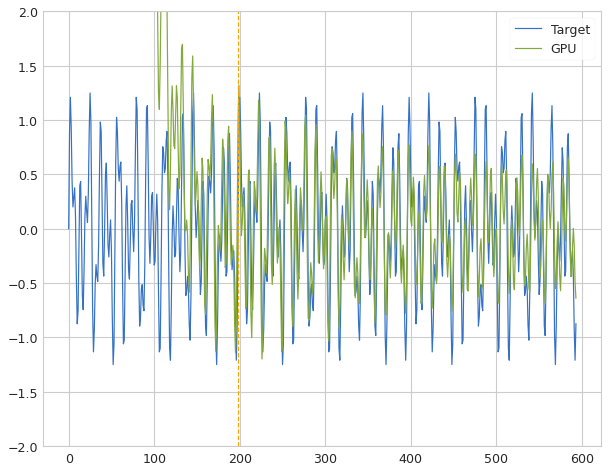

 Iter=16 a=0.326 sr=1.122 amp=0.943  ri=0.084 rr=0.976 loss=0.131427


Iter: 16 #### Diagnostic 0.131   Time 0.77  Best 0.131 NRMSE 0.131 CD 0.152
Iter: 17 #### Diagnostic 0.281   Time 1.06  Best 0.131 NRMSE 0.281 CD 1.170
Iter: 18 #### Diagnostic 0.246   Time 0.41  Best 0.131 NRMSE 0.246 CD 0.984
Iter: 19 #### Diagnostic 0.238   Time 0.39  Best 0.131 NRMSE 0.238 CD 0.765
Iter: 20 #### Diagnostic 0.245   Time 0.50  Best 0.131 NRMSE 0.245 CD 0.964
Iter: 21 #### Diagnostic 0.262   Time 0.43  Best 0.131 NRMSE 0.262 CD 0.997
Iter: 22 #### Diagnostic 0.237   Time 0.39  Best 0.131 NRMSE 0.237 CD 0.731
Iter: 23 #### Diagnostic 0.168   Time 0.33  Best 0.131 NRMSE 0.168 CD 0.238
Iter: 24 #### Diagnostic 0.244   Time 0.20  Best 0.131 NRMSE 0.244 CD 0.858
Iter: 25 #### Diagnostic 1000.000   Time 0.34  Best 0.131 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 0.243   Time 0.30  Best 0.131 NRMSE 0.243 CD 0.848
Iter: 27 #### Diagnostic 0.181   Time 0.30  Best 0.131 NRMSE 0.181 CD 0.315
Iter: 28 ####

Iter: 20 #### Diagnostic 0.236   Time 0.43  Best 1000.000 NRMSE 0.236 CD 0.725
Iter: 21 #### Diagnostic 0.228   Time 0.75  Best 1000.000 NRMSE 0.228 CD 0.634
Iter: 22 #### Diagnostic 0.270   Time 0.57  Best 1000.000 NRMSE 0.270 CD 0.893
Iter: 23 #### Diagnostic 0.245   Time 0.41  Best 1000.000 NRMSE 0.245 CD 0.939
Iter: 24 #### Diagnostic 0.240   Time 0.35  Best 1000.000 NRMSE 0.240 CD 0.787
Iter: 25 #### Diagnostic 0.255   Time 0.50  Best 1000.000 NRMSE 0.255 CD 0.961
Iter: 26 #### Diagnostic 0.256   Time 0.51  Best 1000.000 NRMSE 0.256 CD 0.959
Iter: 27 #### Diagnostic 0.242   Time 0.36  Best 1000.000 NRMSE 0.242 CD 0.822
Iter: 28 #### Diagnostic 0.235   Time 0.57  Best 1000.000 NRMSE 0.235 CD 0.708
Iter: 29 #### Diagnostic 1000.000   Time 0.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 0.246   Time 0.41  Best 1000.000 NRMSE 0.246 CD 0.981
Iter: 31 #### Diagnostic 0.242   Time 0.62  Best 1000.000 NRMSE 0.242 CD 0.827
Iter: 32 #### Diagnostic 0.250   Time 0.32  Best

Iter: 14 #### Diagnostic 0.253   Time 0.33  Best 1000.000 NRMSE 0.253 CD 0.952
Iter: 15 #### Diagnostic 0.246   Time 0.29  Best 1000.000 NRMSE 0.246 CD 0.907
Iter: 16 #### Diagnostic 0.246   Time 0.38  Best 1000.000 NRMSE 0.246 CD 0.814
Iter: 17 #### Diagnostic 0.242   Time 0.30  Best 1000.000 NRMSE 0.242 CD 0.840
Iter: 18 #### Diagnostic 0.232   Time 0.35  Best 1000.000 NRMSE 0.232 CD 0.672
Iter: 19 #### Diagnostic 0.244   Time 0.59  Best 1000.000 NRMSE 0.244 CD 0.900
Iter: 20 #### Diagnostic 0.217   Time 0.23  Best 1000.000 NRMSE 0.217 CD 0.517
Iter: 21 #### Diagnostic 0.245   Time 0.28  Best 1000.000 NRMSE 0.245 CD 0.898
Iter: 22 #### Diagnostic 0.313   Time 0.33  Best 1000.000 NRMSE 0.313 CD 1.051
Iter: 23 #### Diagnostic 0.186   Time 0.38  Best 1000.000 NRMSE 0.186 CD 0.289
Iter: 24 #### Diagnostic 0.246   Time 0.30  Best 1000.000 NRMSE 0.246 CD 0.901
Iter: 25 #### Diagnostic 0.179   Time 0.33  Best 1000.000 NRMSE 0.179 CD 0.292
Iter: 26 #### Diagnostic 0.243   Time 0.51  Best 100

Iter: 16 #### Diagnostic 0.238   Time 0.47  Best 1000.000 NRMSE 0.238 CD 0.708
Iter: 17 #### Diagnostic 0.245   Time 0.38  Best 1000.000 NRMSE 0.245 CD 0.950
Iter: 18 #### Diagnostic 0.225   Time 0.42  Best 1000.000 NRMSE 0.225 CD 0.605
Iter: 19 #### Diagnostic 1000.000   Time 0.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 0.244   Time 0.69  Best 1000.000 NRMSE 0.244 CD 0.915
Iter: 21 #### Diagnostic 0.243   Time 0.66  Best 1000.000 NRMSE 0.243 CD 0.849
Iter: 22 #### Diagnostic 0.246   Time 0.58  Best 1000.000 NRMSE 0.246 CD 1.007
Iter: 23 #### Diagnostic 0.253   Time 0.35  Best 1000.000 NRMSE 0.253 CD 0.929
Iter: 24 #### Diagnostic 0.180   Time 0.33  Best 1000.000 NRMSE 0.180 CD 0.293
Iter: 25 #### Diagnostic 0.247   Time 0.36  Best 1000.000 NRMSE 0.247 CD 0.898
Iter: 26 #### Diagnostic 0.233   Time 0.35  Best 1000.000 NRMSE 0.233 CD 0.680
Iter: 27 #### Diagnostic 0.237   Time 0.38  Best 1000.000 NRMSE 0.237 CD 0.724
Iter: 28 #### Diagnostic 0.245   Time 0.39  Best

Iter: 18 #### Diagnostic 0.251   Time 0.54  Best 1000.000 NRMSE 0.251 CD 0.927
Iter: 19 #### Diagnostic 0.260   Time 0.32  Best 1000.000 NRMSE 0.260 CD 0.922
Iter: 20 #### Diagnostic 0.242   Time 0.65  Best 1000.000 NRMSE 0.242 CD 0.812
Iter: 21 #### Diagnostic 0.253   Time 0.30  Best 1000.000 NRMSE 0.253 CD 0.969
Iter: 22 #### Diagnostic 0.248   Time 0.73  Best 1000.000 NRMSE 0.248 CD 0.901
Iter: 23 #### Diagnostic 0.247   Time 0.92  Best 1000.000 NRMSE 0.247 CD 0.917
Iter: 24 #### Diagnostic 0.279   Time 0.46  Best 1000.000 NRMSE 0.279 CD 0.991
Iter: 25 #### Diagnostic 0.278   Time 0.63  Best 1000.000 NRMSE 0.278 CD 1.106
Iter: 26 #### Diagnostic 0.233   Time 0.63  Best 1000.000 NRMSE 0.233 CD 0.683
Iter: 27 #### Diagnostic 0.230   Time 0.30  Best 1000.000 NRMSE 0.230 CD 0.653
Iter: 28 #### Diagnostic 0.149   Time 0.46  Best 1000.000 NRMSE 0.149 CD 0.198
Iter: 29 #### Diagnostic 0.250   Time 0.33  Best 1000.000 NRMSE 0.250 CD 0.954
Iter: 30 #### Diagnostic 0.243   Time 0.20  Best 100

Iter: 19 #### Diagnostic 0.237   Time 0.48  Best 1000.000 NRMSE 0.237 CD 0.745
Iter: 20 #### Diagnostic 0.245   Time 0.47  Best 1000.000 NRMSE 0.245 CD 0.965
Iter: 21 #### Diagnostic 0.261   Time 0.67  Best 1000.000 NRMSE 0.261 CD 0.993
Iter: 22 #### Diagnostic 0.295   Time 0.95  Best 1000.000 NRMSE 0.295 CD 1.253
Iter: 23 #### Diagnostic 0.168   Time 0.76  Best 1000.000 NRMSE 0.168 CD 0.235
Iter: 24 #### Diagnostic 0.249   Time 0.55  Best 1000.000 NRMSE 0.249 CD 0.931
Iter: 25 #### Diagnostic 0.259   Time 0.35  Best 1000.000 NRMSE 0.259 CD 0.701
Iter: 26 #### Diagnostic 0.245   Time 0.39  Best 1000.000 NRMSE 0.245 CD 0.873
Iter: 27 #### Diagnostic 0.172   Time 0.67  Best 1000.000 NRMSE 0.172 CD 0.276
Iter: 28 #### Diagnostic 0.244   Time 0.35  Best 1000.000 NRMSE 0.244 CD 0.811
Iter: 29 #### Diagnostic 0.246   Time 0.56  Best 1000.000 NRMSE 0.246 CD 0.990
Iter: 30 #### Diagnostic 0.192   Time 0.74  Best 1000.000 NRMSE 0.192 CD 0.348
Iter: 31 #### Diagnostic 1000.000   Time 0.51  Best 

Iter: 21 #### Diagnostic 0.228   Time 0.36  Best 1000.000 NRMSE 0.228 CD 0.633
Iter: 22 #### Diagnostic 0.277   Time 0.42  Best 1000.000 NRMSE 0.277 CD 0.894
Iter: 23 #### Diagnostic 0.245   Time 0.40  Best 1000.000 NRMSE 0.245 CD 0.947
Iter: 24 #### Diagnostic 0.247   Time 0.20  Best 1000.000 NRMSE 0.247 CD 0.906
Iter: 25 #### Diagnostic 0.255   Time 0.27  Best 1000.000 NRMSE 0.255 CD 0.961
Iter: 26 #### Diagnostic 0.252   Time 0.40  Best 1000.000 NRMSE 0.252 CD 0.927
Iter: 27 #### Diagnostic 0.242   Time 0.33  Best 1000.000 NRMSE 0.242 CD 0.829
Iter: 28 #### Diagnostic 0.255   Time 0.49  Best 1000.000 NRMSE 0.255 CD 0.951
Iter: 29 #### Diagnostic 0.188   Time 0.33  Best 1000.000 NRMSE 0.188 CD 0.310
Iter: 30 #### Diagnostic 0.246   Time 0.66  Best 1000.000 NRMSE 0.246 CD 0.984
Iter: 31 #### Diagnostic 0.242   Time 0.93  Best 1000.000 NRMSE 0.242 CD 0.838
Iter: 32 #### Diagnostic 0.251   Time 0.41  Best 1000.000 NRMSE 0.251 CD 0.946
Iter: 33 #### Diagnostic 0.244   Time 0.30  Best 100

In [ ]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)

size = [300,200,100,50]
rand_state = [11,37,3,24,91]

for N in size:
    min_a, max_a = .001, 1.
    min_sr, max_sr = .001, 1.2
    min_g, max_g = .001, 1.
    min_ri, max_ri = .001, 1.
    min_rr, max_rr = .001, 5.
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(5):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []

        for rn in range(5):
            running_error = 1000
            counter = 0 
            print(f'\n ********** {N} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=-1,
                                    n_initial_points=100)
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')

        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')

## End Model

In [ ]:
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

iteration = [18,18,79,36,47,16,59,36,91,43,133,43,111,43,135,43,80,0,43,39]
size = [1000]#,950,900,850,800,750,700,650,600,550,500,
        #450,400,350,300,250,200,150,100,50]

TOLS = [1/10**(x) for x in range(0,20)]
mm_ranks = []
for ctr,N in zip(iteration,size):
    fn_mats = f'./MultiModelMG/Mats/MG_it{ctr}_{N}_Wnet.npy'
    fn_params = f'./MultiModelMG/Params/MG_it{ctr}_{N}_InstanceParams.npy'
    p = np.load(fn_params, allow_pickle=True)
    a,g = p[0],p[2]

    Wr, Wi = rca.get_mats(fn_mats, K, N)
    xeq = np.zeros((N,1))
    ueq = np.zeros((K,1))
    A = rca.leaky_jacobian(xeq, ueq, a, g, Wi, Wr)
    B = rca.partial_u(xeq, ueq, a, g, Wi, Wr)

    Cplus = np.nan_to_num(rca.reachable_matrix(A, B),0,0,0)
    spec = np.linalg.eigvals(Cplus)
    evs= np.abs(spec)
    Cplus = Cplus/np.max(evs)
    rkc = rank_curve(Cplus,TOLS)
    v = np.argmax(np.gradient(rkc))-1
    ave_rank = (rkc[v]+rkc[v+1])/2
    print(f'Pair: iter {ctr} size {N} argmax {v} {v+1} tol {TOLS[v]} ave {ave_rank}')
    mm_ranks.append(ave_rank)

In [ ]:
    
np.save('./MultiModelMG/MG_MMranks',np.array(mm_ranks))

In [ ]:
plt.plot(size,mm_ranks)
plt.show()

In [ ]:
minmax = np.max(signal[:TRAINLENGTH+TEST])-np.min(signal[:TRAINLENGTH+TEST])
err_list = []
for ctr,N in zip(iteration,size):
    pred = np.load(f'./MultiModelMG/Preds/MG_it{ctr}_{N}_Preds.npy', allow_pickle=True)
    nrmse = mean_squared_error(signal[TRAINLENGTH:TRAINLENGTH+TEST],pred[TRAINLENGTH:TRAINLENGTH+TEST],
                               squared=False, multioutput='raw_values')
    print(nrmse/minmax)
    err_list.append(nrmse/minmax)
np.save('./MultiModelMG/MG_mm_errors',np.array(err_list))

plt.plot(size,err_list)
plt.show()

In [ ]:
total = 0.
no_outliers = []
for i in range(len(mm_ranks)):
    if(size[i] in [600,1000]):
        pass
    else:
        total += mm_ranks[i]
        no_outliers.append(mm_ranks[i])
total/(len(mm_ranks)-2)